# Our goal is to predict the Churn out of a bank.

This project is being developed by:
- Jorge Rodrigo Velázquez
- Leandro Sartini de Campos
- Mohamed Maaz Rehan
- Aman Nain
- Prakash Pun
- Saraka Sahaswin
- Bibek Ranjit

### Step by step of what we are going to do

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,roc_auc_score,f1_score,roc_curve,auc
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss
import warnings
warnings.filterwarnings('ignore')

In [93]:
df = pd.read_csv('bank_data_train.csv')

Checking info

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355190 entries, 0 to 355189
Columns: 116 entries, ID to TARGET
dtypes: float64(94), int64(9), object(13)
memory usage: 314.3+ MB


Checking for null columns with a percentage above 50.
We are going to drop these.

In [95]:
null_counts = df.isnull().sum()

In [96]:
df.shape

(355190, 116)

In [97]:
df.isnull().sum()

ID                               0
CR_PROD_CNT_IL                   0
AMOUNT_RUB_CLO_PRC           38323
PRC_ACCEPTS_A_EMAIL_LINK    200027
APP_REGISTR_RGN_CODE        294640
                             ...  
TURNOVER_DYNAMIC_CC_3M           0
LDEAL_ACT_DAYS_PCT_TR       261742
LDEAL_ACT_DAYS_PCT_TR4      261742
LDEAL_ACT_DAYS_PCT_CURR     261742
TARGET                           0
Length: 116, dtype: int64

In [104]:
df.drop(columns = null_counts[null_counts > df.shape[0] * 0.50].index, inplace = True)

In [105]:
df.shape

(355190, 63)

Dropping ID column as well, because it's not information for the model

In [8]:
df.drop(columns = 'ID',inplace = True)

Let's start EDA with correlation and go from there.

In [9]:
df.shape

(355190, 50)

In [10]:
df.describe(include='all')

CR_PROD_CNT_IL  AMOUNT_RUB_CLO_PRC  TURNOVER_DYNAMIC_IL_1M  \
count    355190.000000       316867.000000           355190.000000   
unique             NaN                 NaN                     NaN   
top                NaN                 NaN                     NaN   
freq               NaN                 NaN                     NaN   
mean          0.105225            0.044045                0.001305   
std           0.431372            0.108449                0.029118   
min           0.000000            0.000000                0.000000   
25%           0.000000            0.000000                0.000000   
50%           0.000000            0.000000                0.000000   
75%           0.000000            0.036608                0.000000   
max          11.000000            1.000000                1.000000   

        AMOUNT_RUB_SUP_PRC  REST_DYNAMIC_FDEP_1M  REST_DYNAMIC_SAVE_3M  \
count        316867.000000         355190.000000         355190.000000   
unique                 NaN                   NaN                   NaN   
top                    NaN                   NaN                   NaN   
freq                   NaN                   NaN                   NaN   
mean              0.085249              0.000723              0.063400   
std               0.142310              0.014081              0.202963   
min               0.000000              0.000000              0.000000   
25%               0.000000              0.000000              0.000000   
50%               0.027117              0.000000              0.000000   
75%               0.110005              0.000000              0.000000   
max               1.000000              1.000000              1.000000   

        CR_PROD_CNT_VCU  REST_AVG_CUR  AMOUNT_RUB_NAS_PRC CLNT_JOB_POSITION  \
count     355190.000000  3.551900e+05       316867.000000            210811   
unique              NaN           NaN                 NaN             19588   
top                 NaN           NaN                 NaN          ДИРЕКТОР   
freq                NaN           NaN                 NaN             11200   
mean           0.031214  6.635854e+04            0.023971               NaN   
std            0.184059  1.878598e+05            0.090774               NaN   
min            0.000000  0.000000e+00            0.000000               NaN   
25%            0.000000  4.070440e+03            0.000000               NaN   
50%            0.000000  1.628925e+04            0.000000               NaN   
75%            0.000000  5.659516e+04            0.010536               NaN   
max            4.000000  2.202141e+07            1.000000               NaN   

        ...  CLNT_SETUP_TENOR  TURNOVER_DYNAMIC_PAYM_3M  \
count   ...     355190.000000             355190.000000   
unique  ...               NaN                       NaN   
top     ...               NaN                       NaN   
freq    ...               NaN                       NaN   
mean    ...          4.377001                  0.071906   
std     ...          2.936530                  0.206863   
min     ...          0.345592                  0.000000   
25%     ...          1.781187                  0.000000   
50%     ...          3.894098                  0.000000   
75%     ...          6.555388                  0.000000   
max     ...         13.748937                  1.000000   

        TURNOVER_DYNAMIC_PAYM_1M  TRANS_AMOUNT_TENDENCY3M  \
count              355190.000000            303194.000000   
unique                       NaN                      NaN   
top                          NaN                      NaN   
freq                         NaN                      NaN   
mean                    0.025108                 0.582237   
std                     0.104482                 0.282157   
min                     0.000000                 0.000000   
25%                     0.000000                 0.383673   
50%                     0.000000                 0.552169   
75%       

Let's check for other variables which we can drop, like Categorical variables with over too many values.

In [11]:
dtypes = df.dtypes

In [12]:
dtypes[dtypes == 'object']

CLNT_JOB_POSITION    object
PACK                 object
dtype: object

Let's check for the client job position first

In [13]:
df['CLNT_JOB_POSITION'].nunique()

19588

In [14]:
df['CLNT_JOB_POSITION'].isnull().sum()

144379

In [15]:
df['CLNT_JOB_POSITION'].unique()

array(['начальник отдела', nan, 'ГЕНЕРАЛЬНЫЙ ДИРЕКТОР', ...,
       'Эксперт контакт Центра', 'ПРОХЛДЧИК',
       'ХУДОЖНИК КОМПЬЮТЕРНОЙ ГРАФИКИ'], dtype=object)

In [16]:
df.drop(columns = 'CLNT_JOB_POSITION',inplace = True)

We will remove it, because the variables are in Russian and also we have over 19k distinct values so there is no way to translate it to less values and use it on our model.

In [17]:
df['PACK'].nunique()

12

In [18]:
df['PACK'].isnull().sum()

0

In [19]:
df['PACK'].unique()

array(['K01', '102', '105', 'O01', '103', '101', '107', '301', '104',
       '108', '109', 'M01'], dtype=object)

We will keep this one because there is only 12 categorical values and no nulls.

First 20 columns + Target

In [20]:
corr = df.corr(numeric_only=True)

In [21]:
corr.shape

(48, 48)

In [22]:
first_cols = list(df.iloc[:,0:25].columns)
first_cols.append('TARGET')

In [23]:
corr = df[first_cols].corr(numeric_only=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

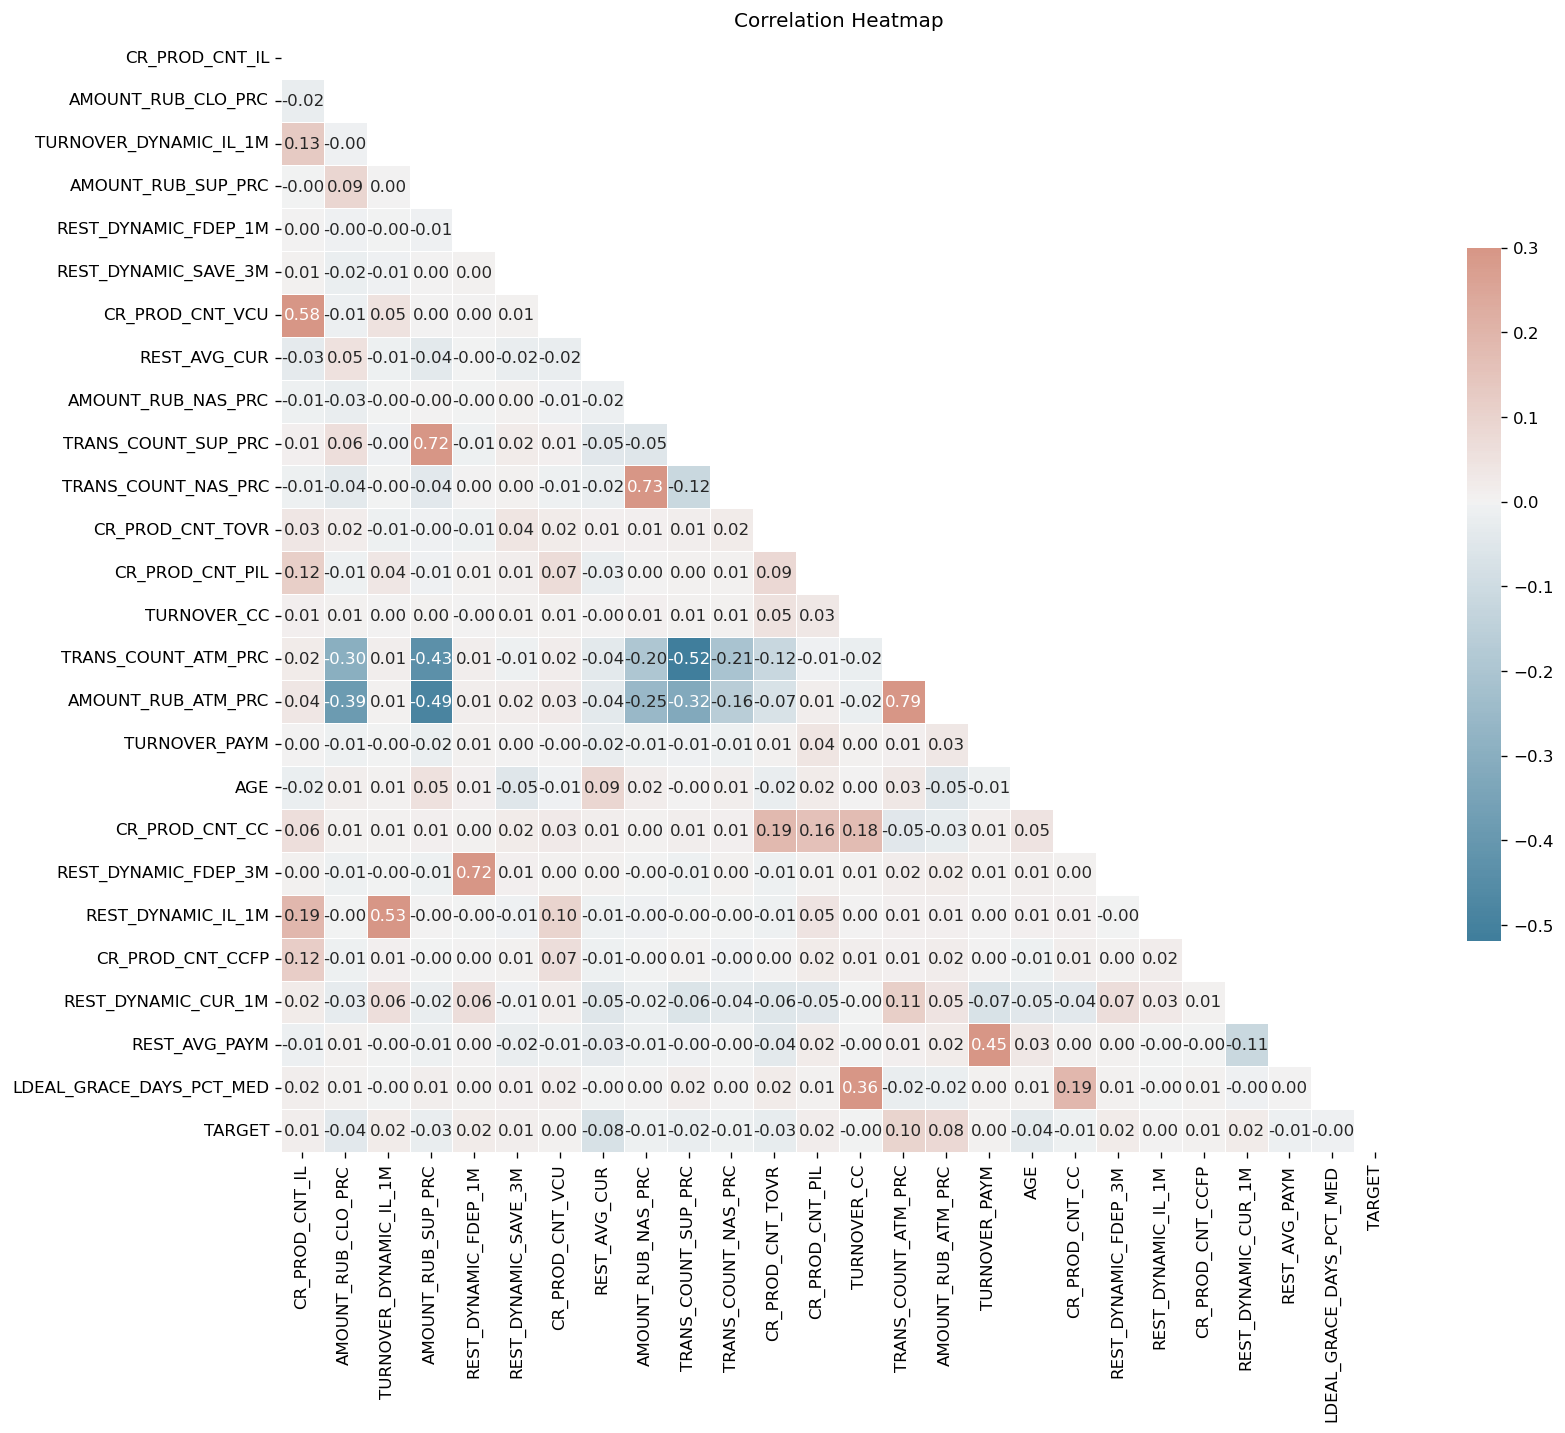

In [24]:
plt.figure(figsize=(15, 15),dpi=120)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.title('Correlation Heatmap', size=12)

plt.show()

So checking for multicolinearity we did find a few which we will be exploring like:

- TRANS_COUNT_SUP_PRC x AMOUNT_RUB_SUP_PRC
- TRANS_COUNT_NAS_PRC x AMOUNT_RUB_NAS_PRC
- TRANS_COUNT_AMT_PRC x AMOUNT_RUB_AMT_PRC
<br>
<b>TRANS_COUNT is the Ratio of MCC Transactions and the Amount transactions in the period, so it makes sense that they are highly correlated because one may be created from the other.</b>
- REST_DYNAMIC_FDEP_3M x REST_DYNAMIC_FDEP_1M
<br>
<b> It makes sense for it to be correlated because one is a lag of 3 months and the other is a lag of 1 month.</b>

Second 20 columns + Target

In [25]:
first_cols = list(df.iloc[:,25:].columns)

In [26]:
corr = df[first_cols].corr(numeric_only=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

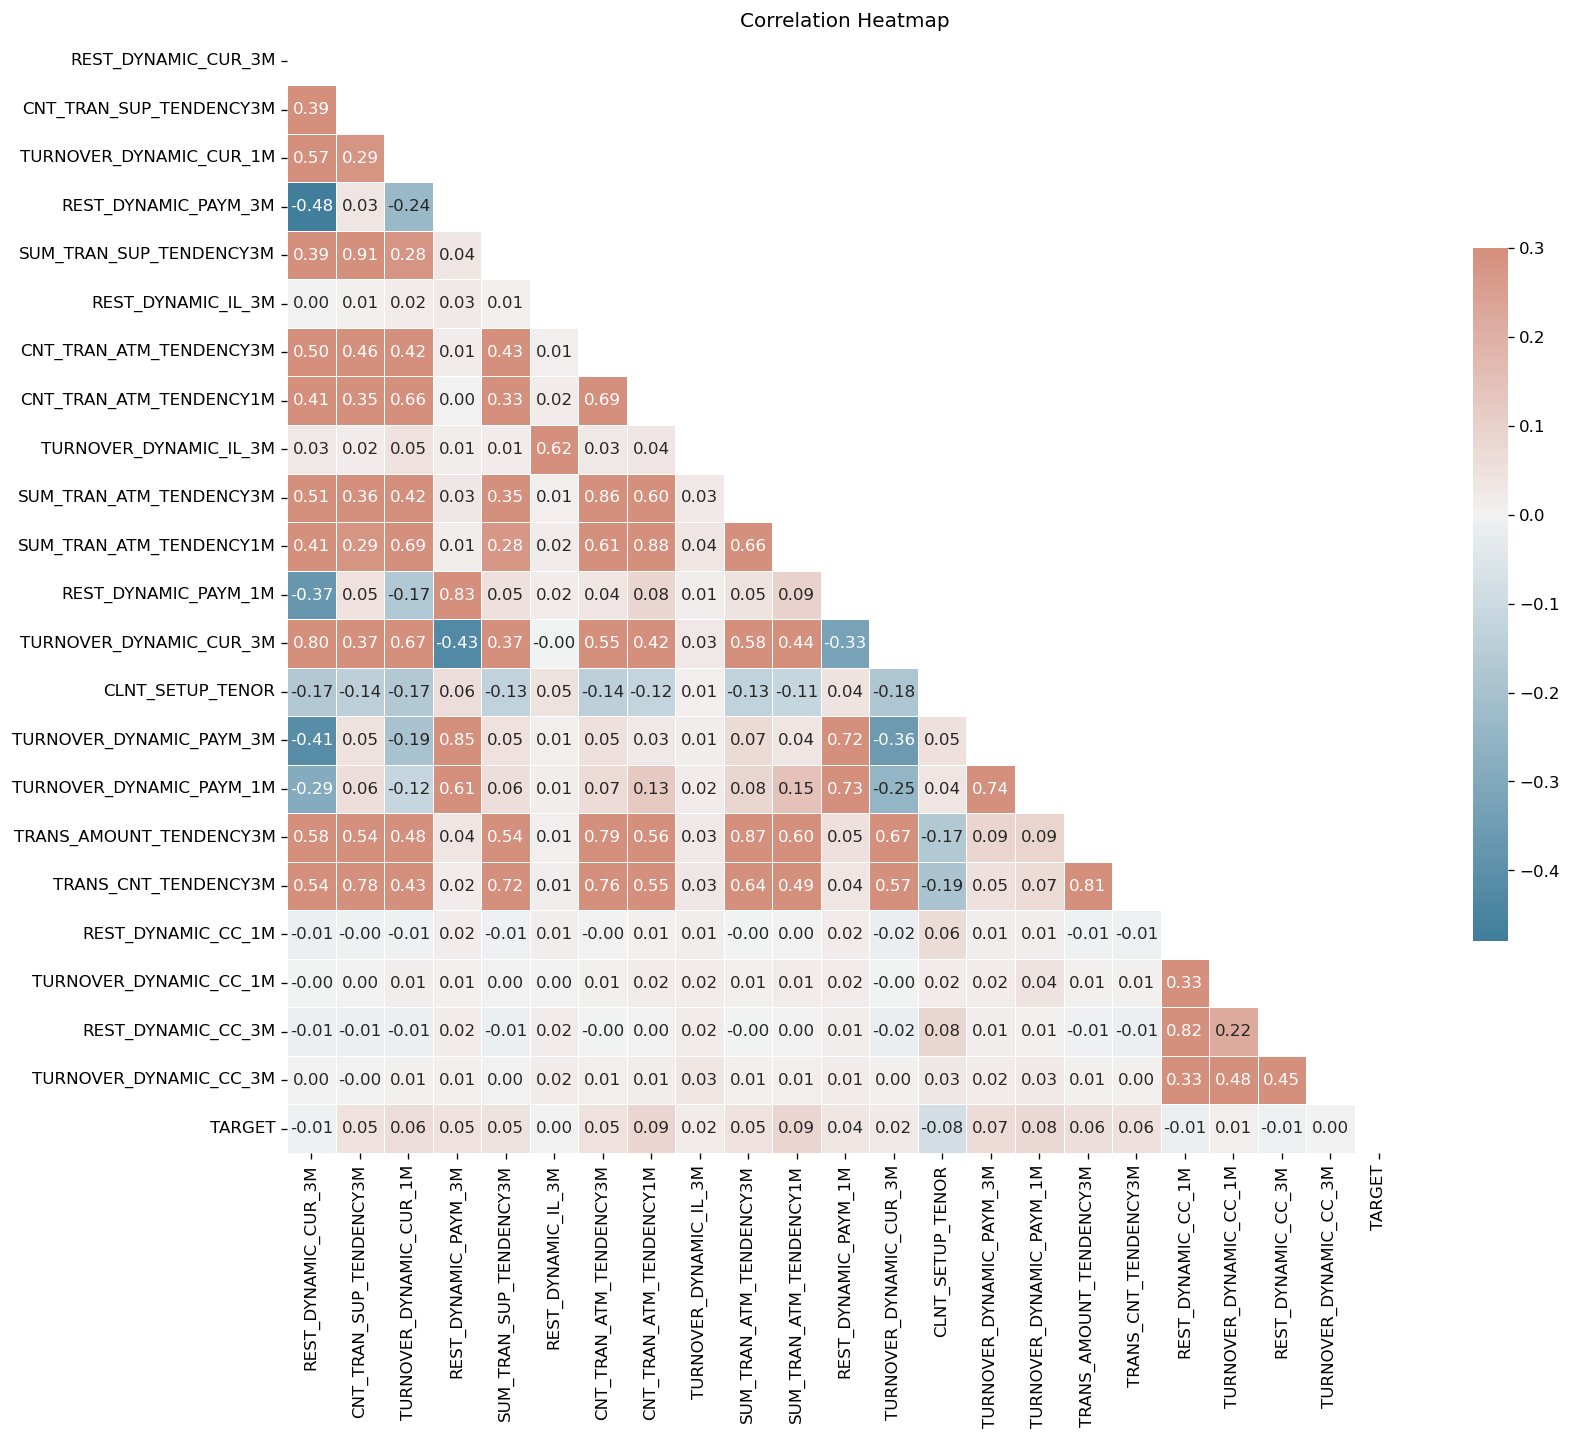

In [27]:
plt.figure(figsize=(15, 15),dpi=120)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.title('Correlation Heatmap', size=12)

plt.show()

Also exploring multicolinearity we find that many variables have a high linear relation between them, and it's given because of lag of them being one created from the other.
<b> Given that we are going to start exploring these relationships to choose what we may or may not keep </b>

Let's create a dataframe with our highly correlated variables, and then from there we can start plotting

In [28]:
corr = df.corr(numeric_only=True)

In [29]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
corr_pairs = corr.where(mask).stack()

In [30]:
high_corr_pairs = corr_pairs[abs(corr_pairs) > 0.6]

In [31]:
high_corr_df = high_corr_pairs.to_frame().reset_index().rename(columns = {'level_0' : 'col1','level_1' : 'col2'}).drop(columns = 0)

In [32]:
high_corr_df.sample(3)

col1                     col2
26  CNT_TRAN_ATM_TENDENCY3M     TRANS_CNT_TENDENCY3M
11      REST_DYNAMIC_CUR_3M  TURNOVER_DYNAMIC_CUR_3M
36       REST_DYNAMIC_CC_1M       REST_DYNAMIC_CC_3M

From here we can start plotting using col 1 and col 2 versus the target

In [33]:
high_corr_df['col1'].iloc[0]

'TURNOVER_DYNAMIC_IL_1M'

I will leave the piece of code which we used to check if they are equally distributed between the 2 binarys variables.
With this we can see that the relationship between them are equal so we can pick between one or the other.

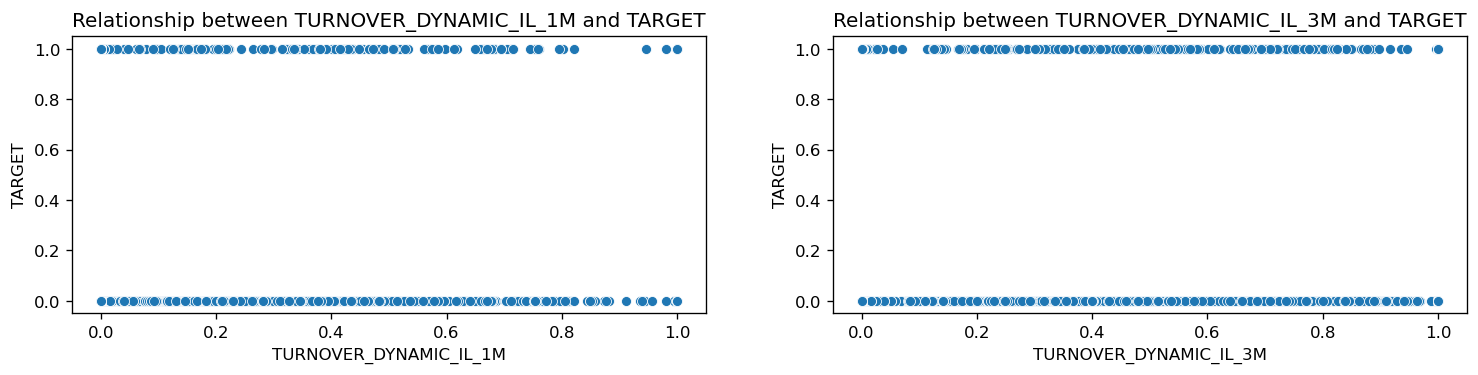

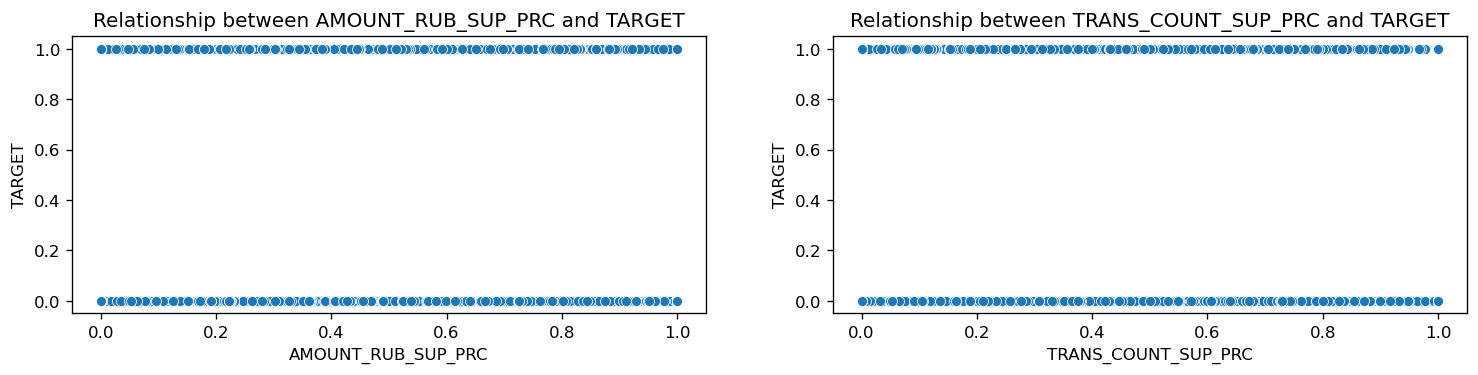

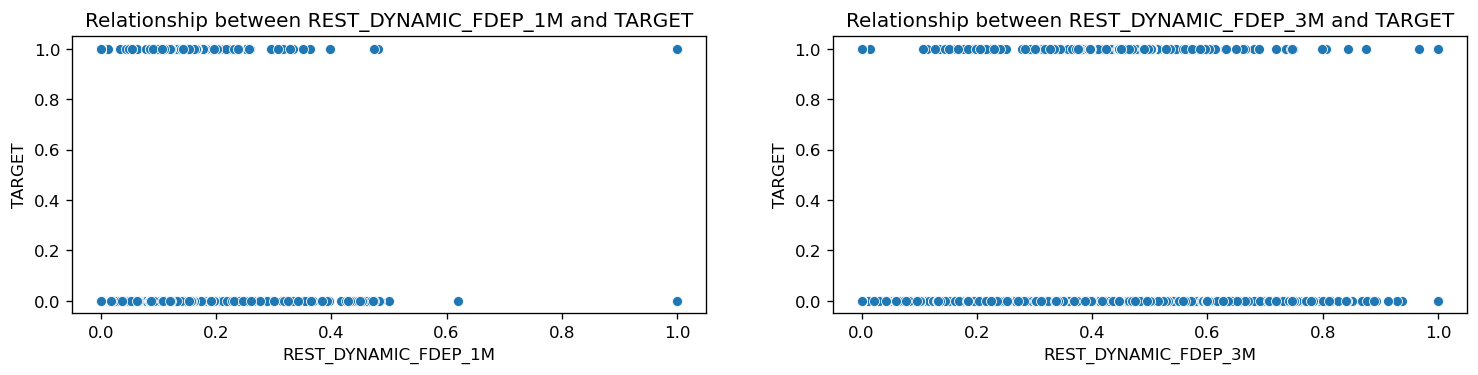

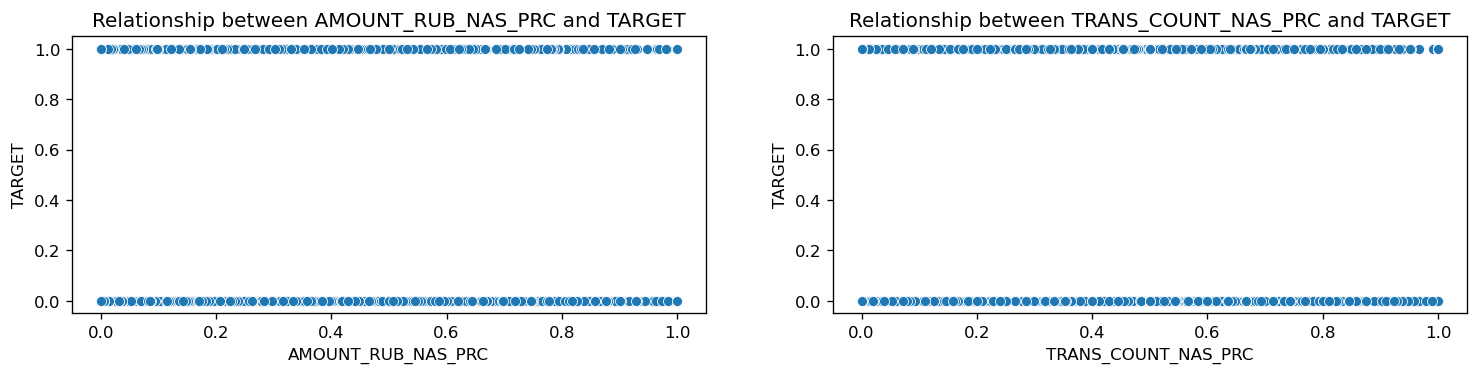

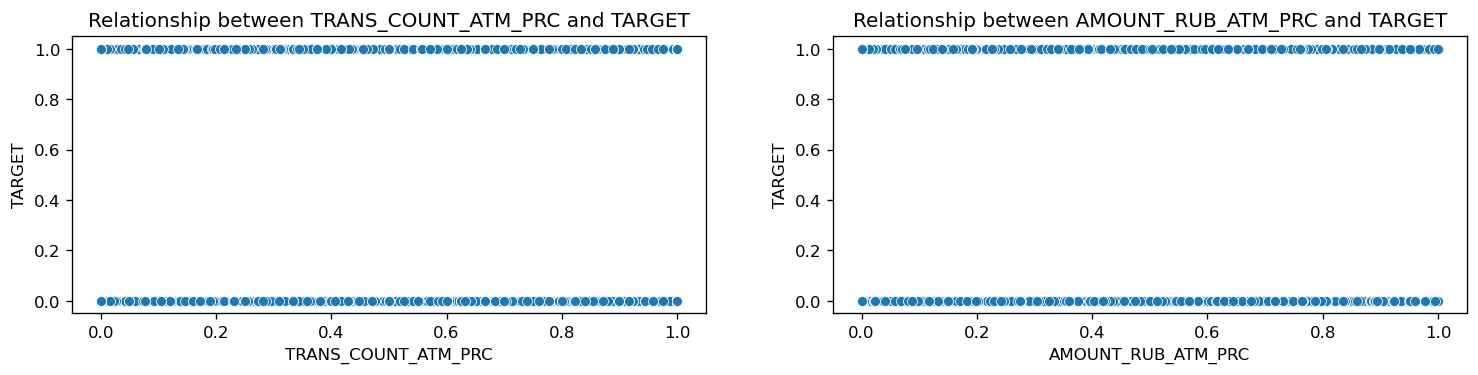

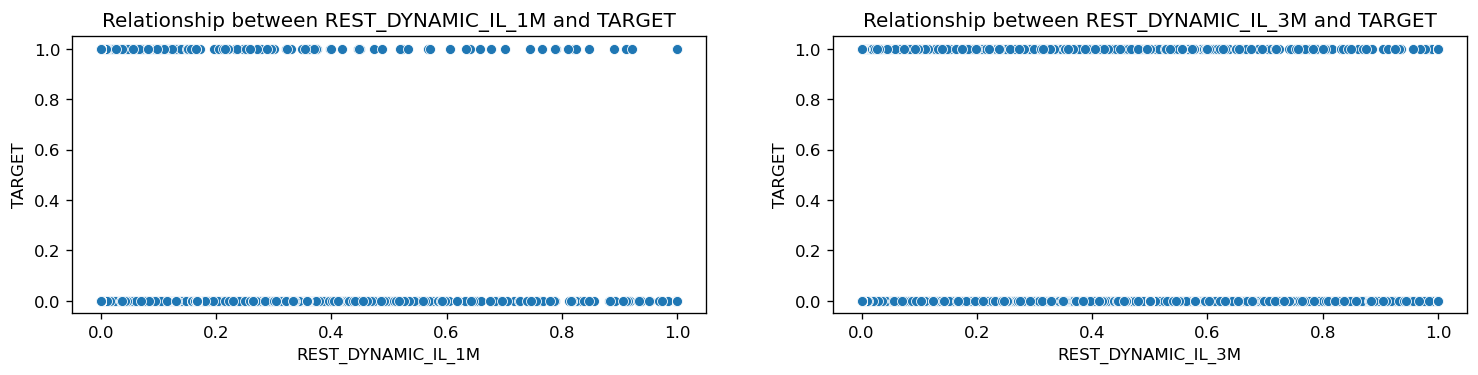

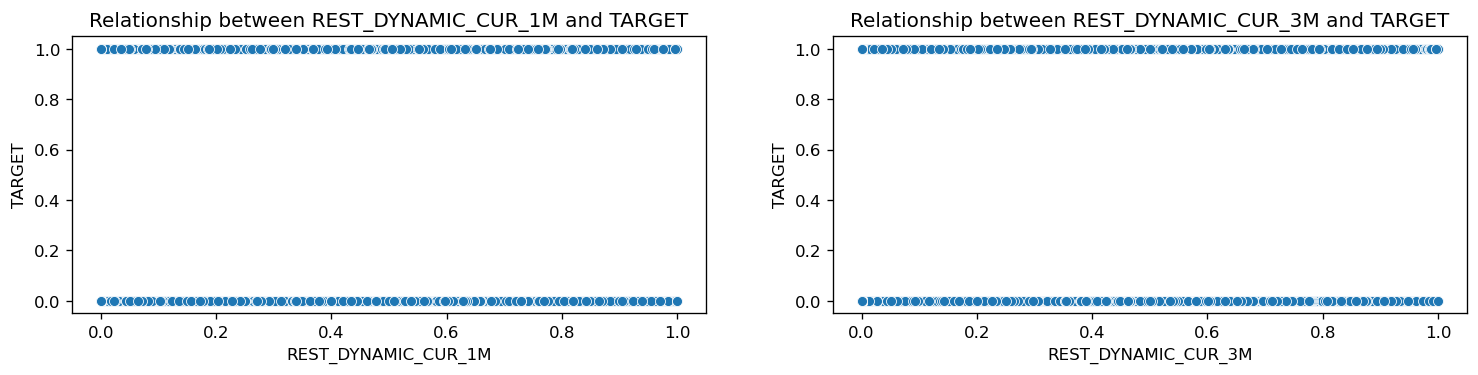

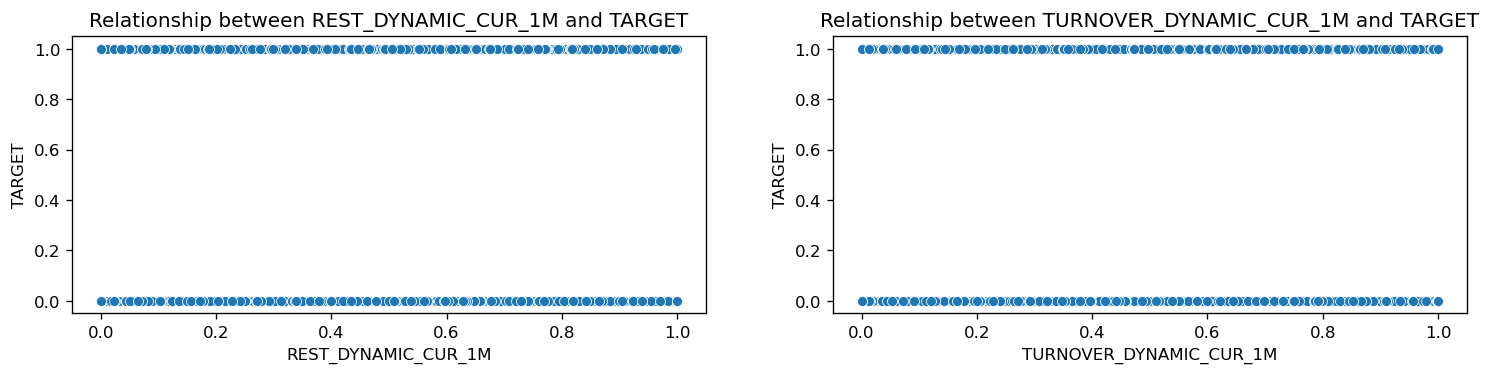

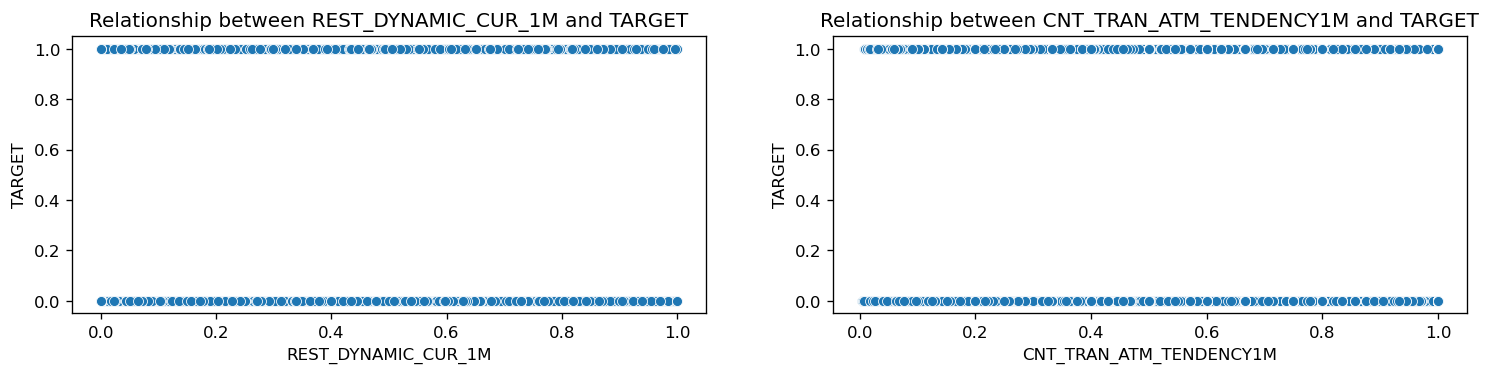

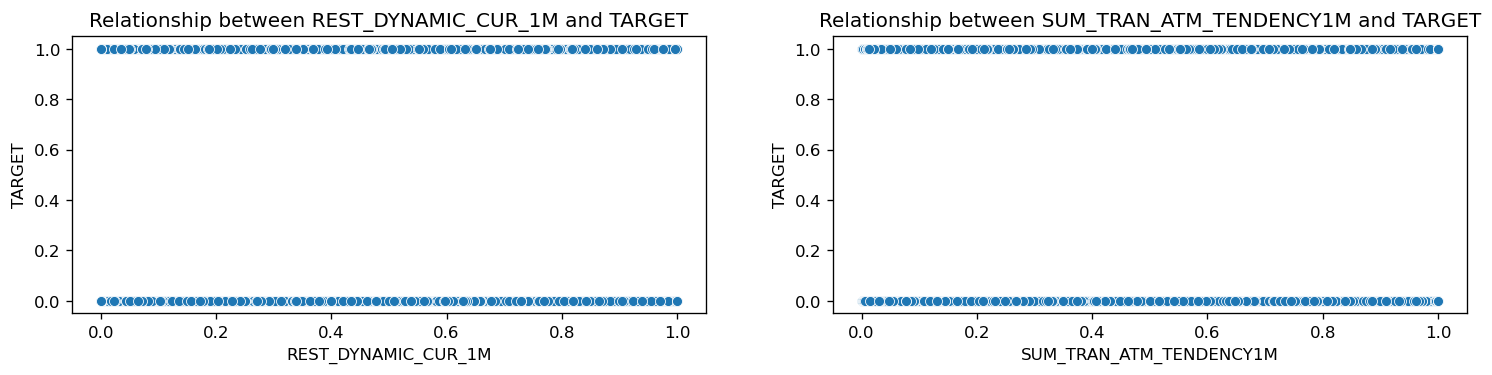

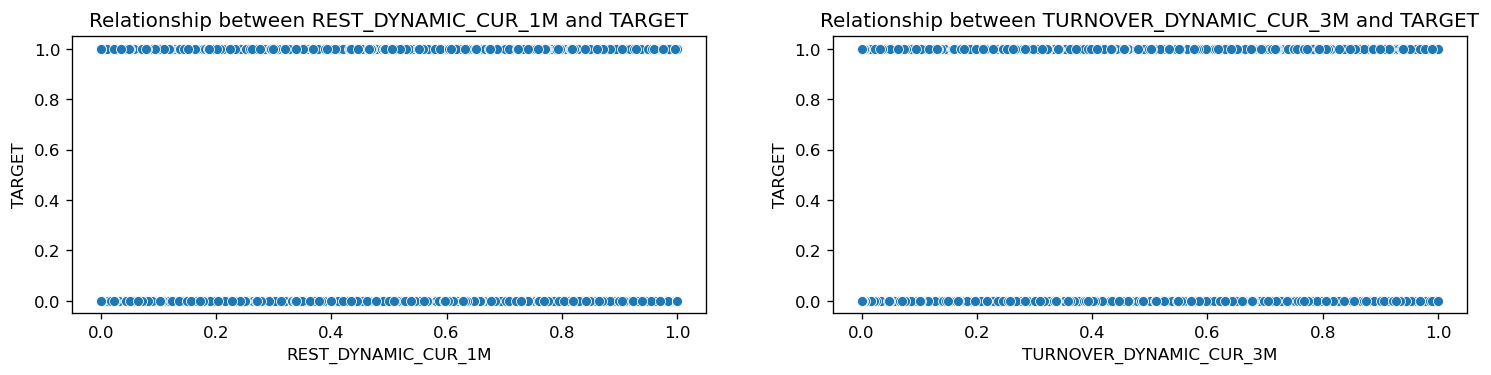

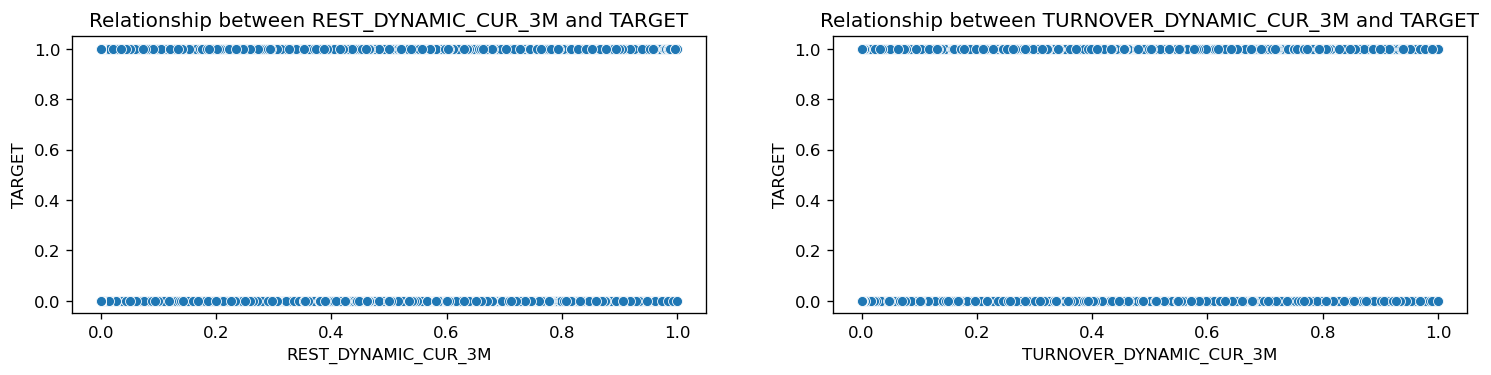

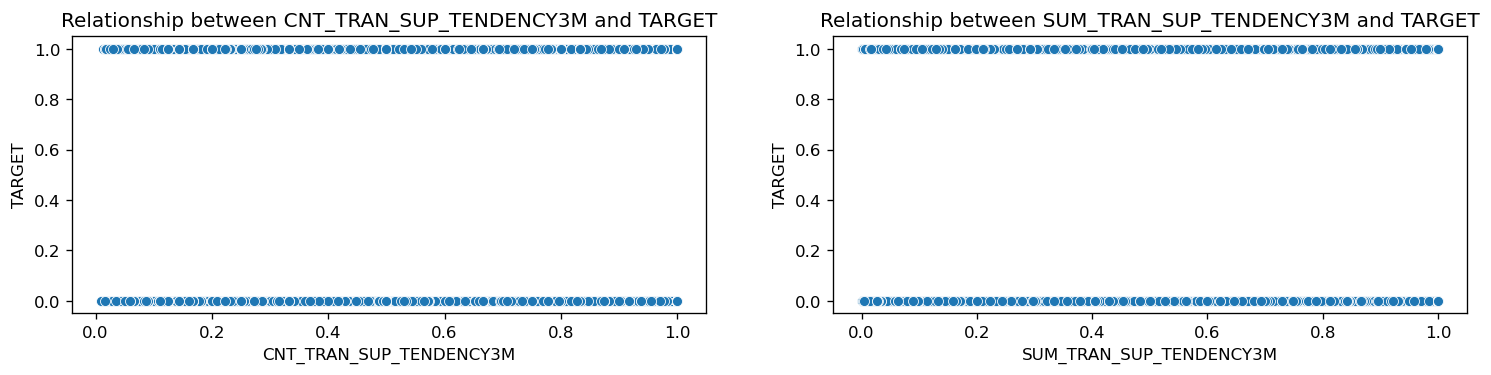

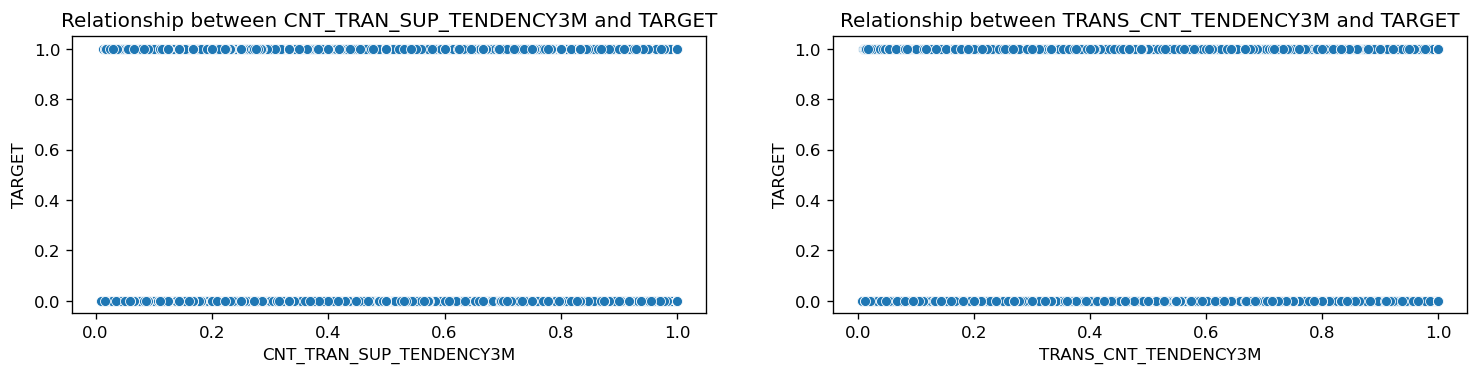

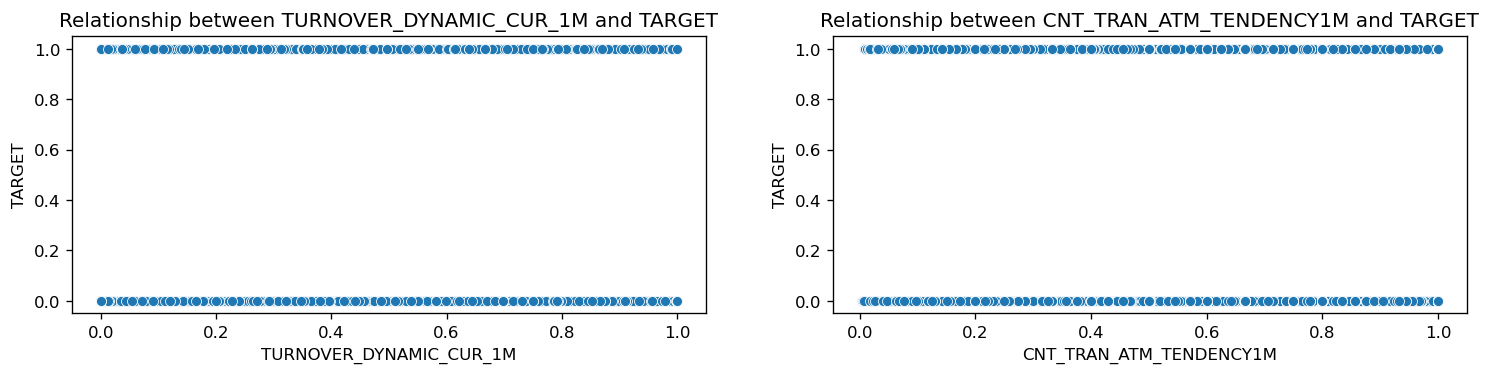

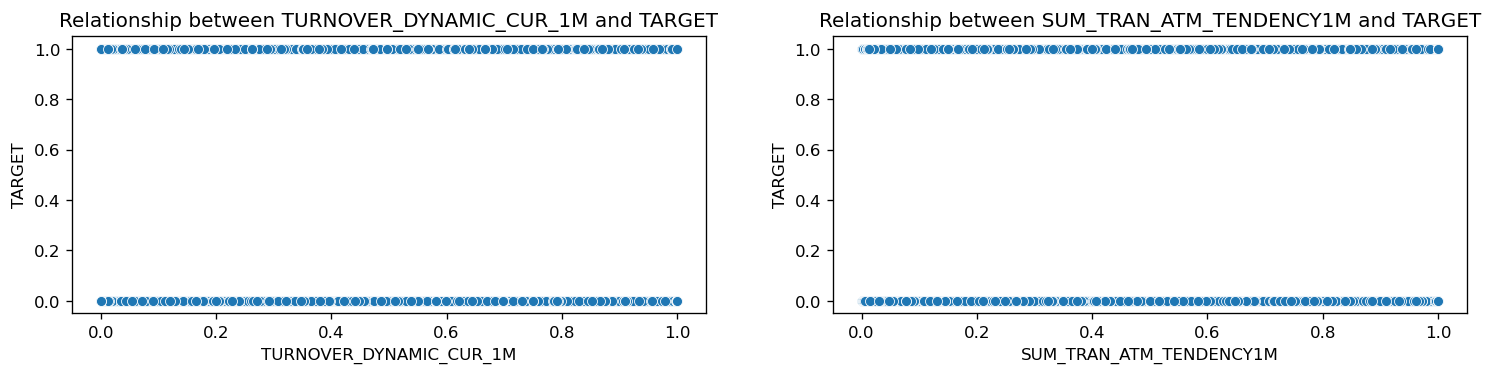

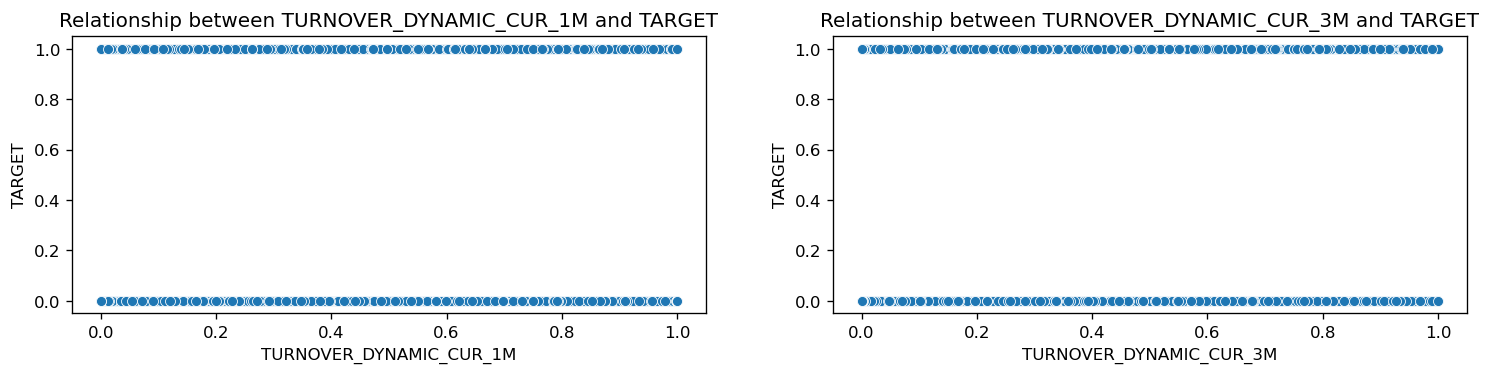

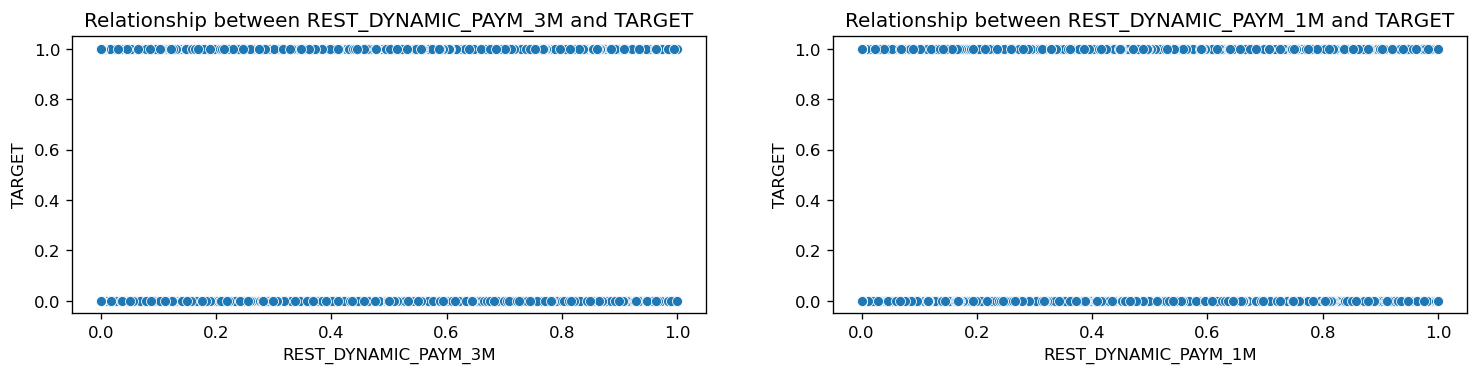

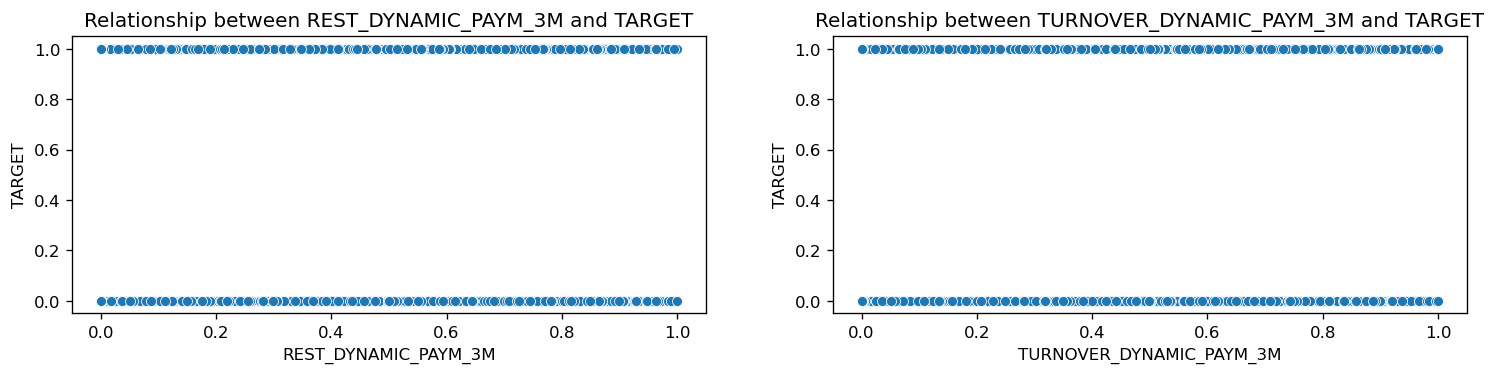

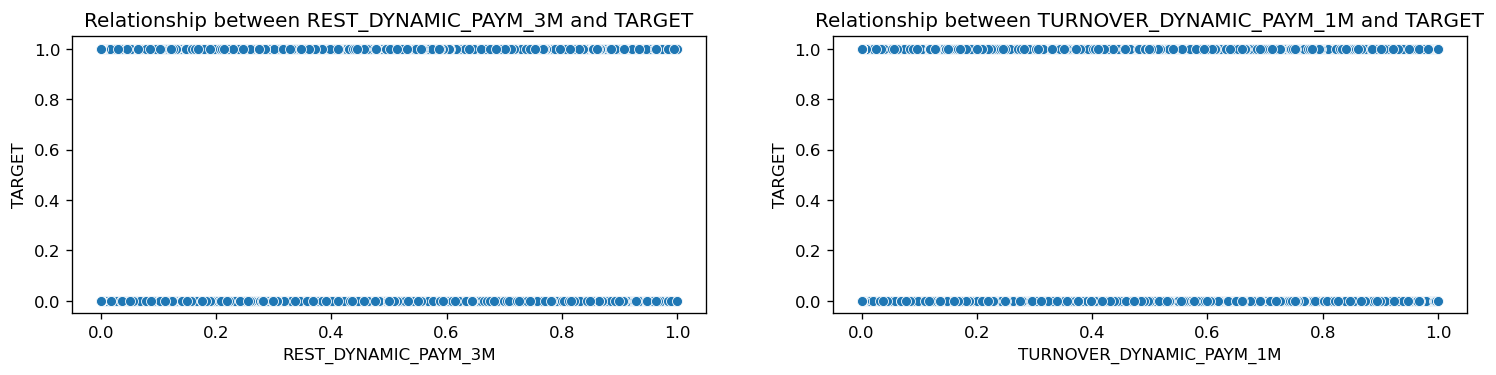

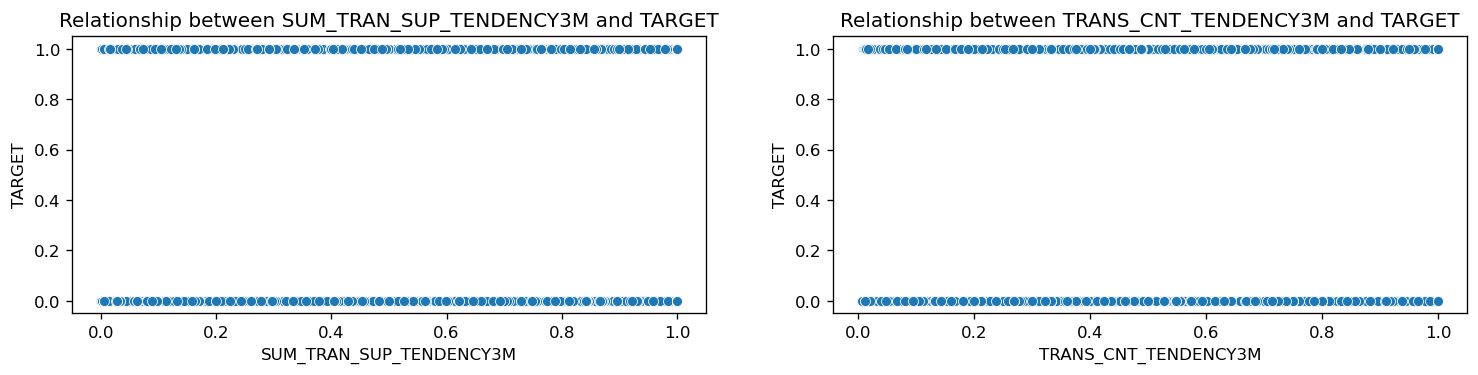

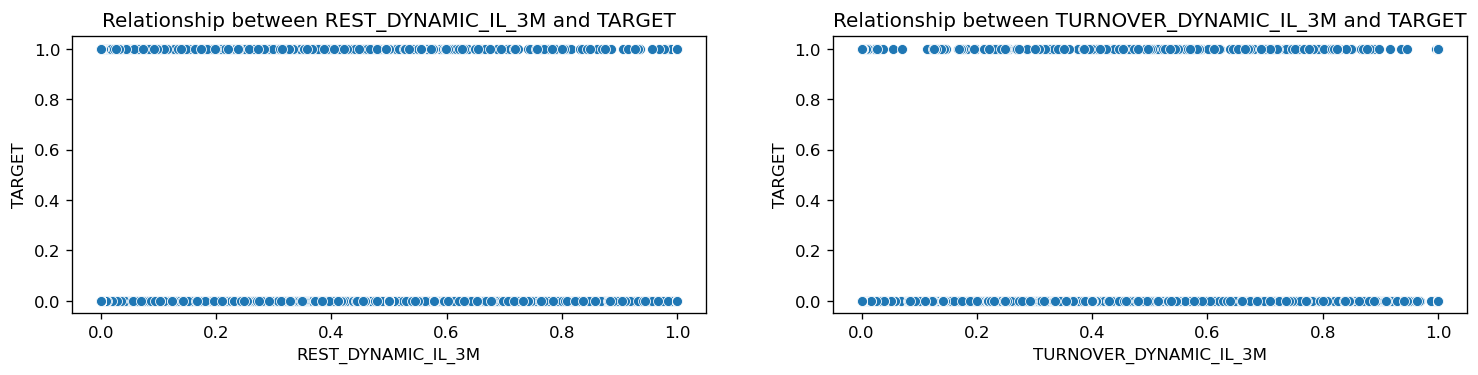

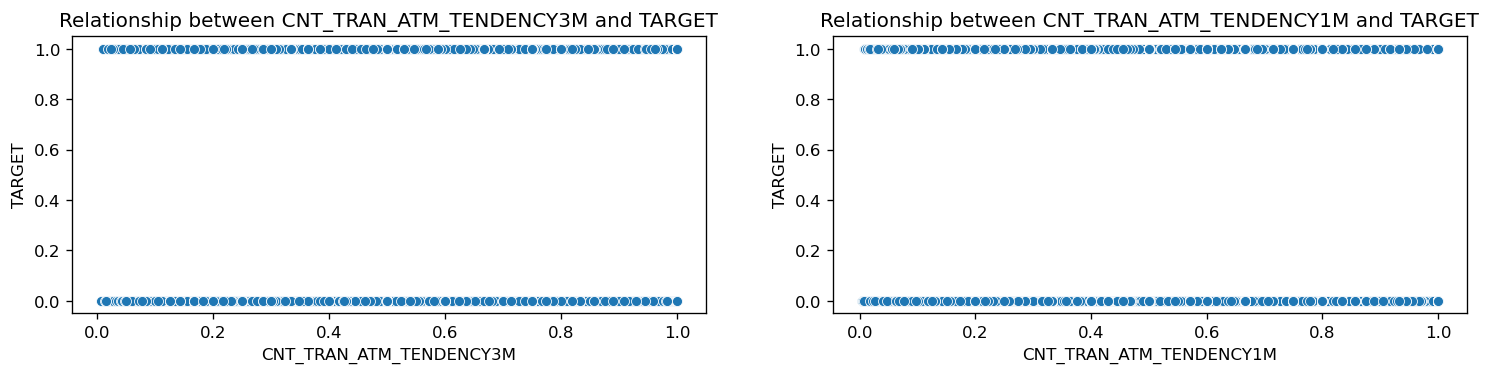

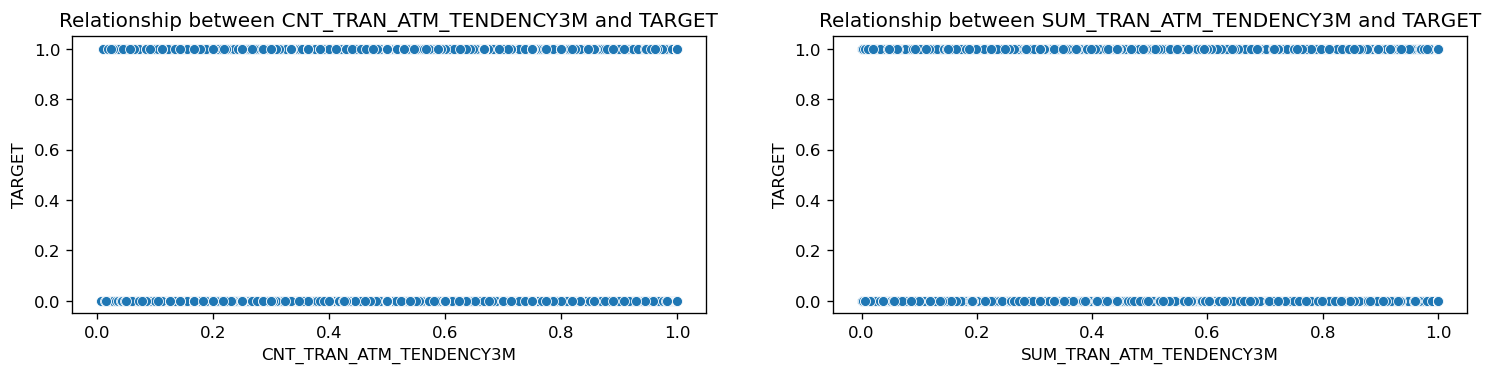

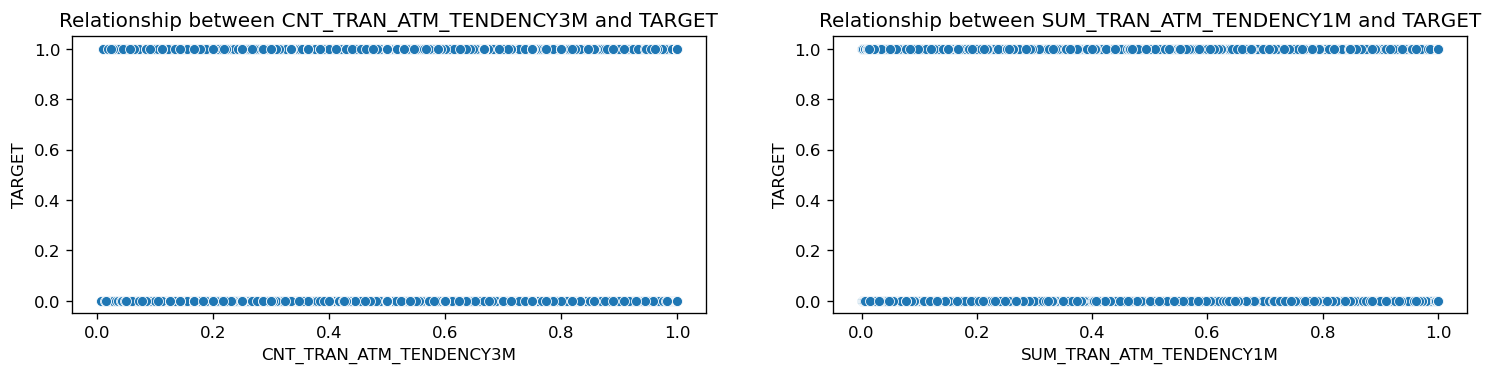

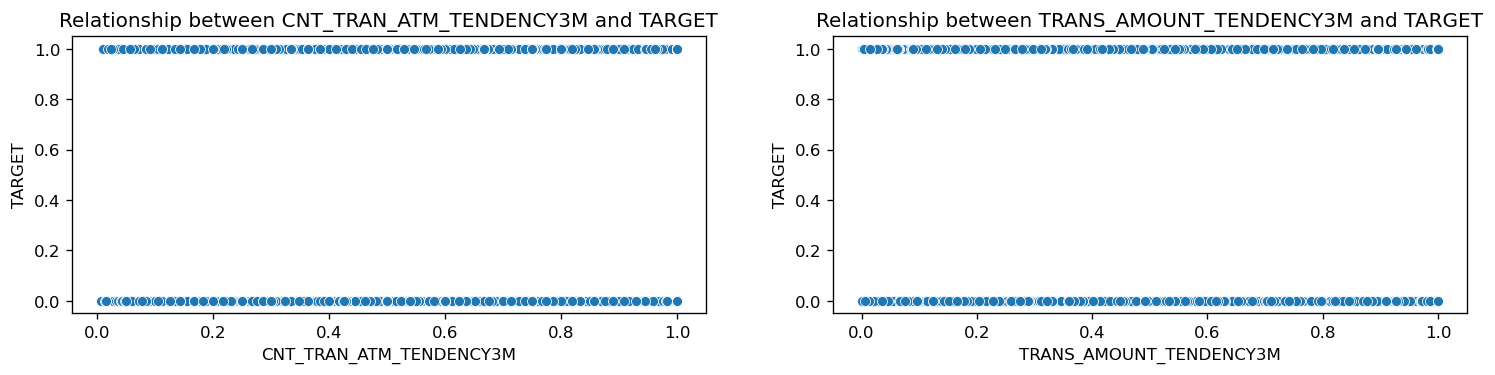

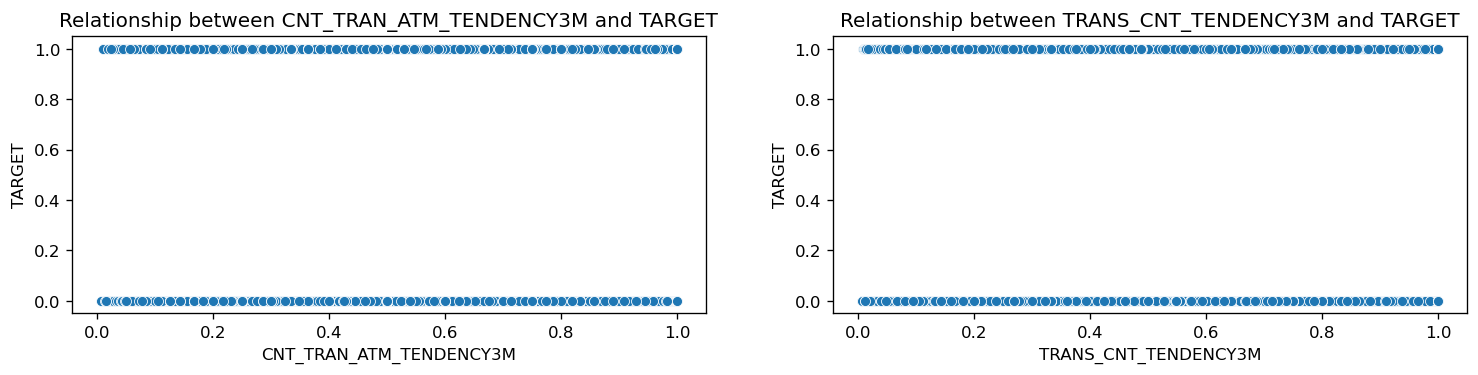

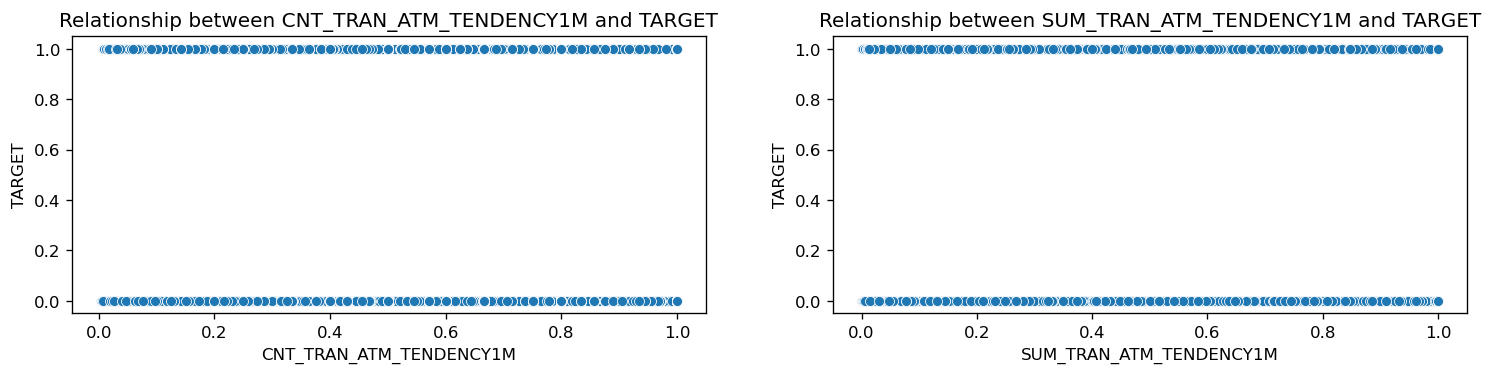

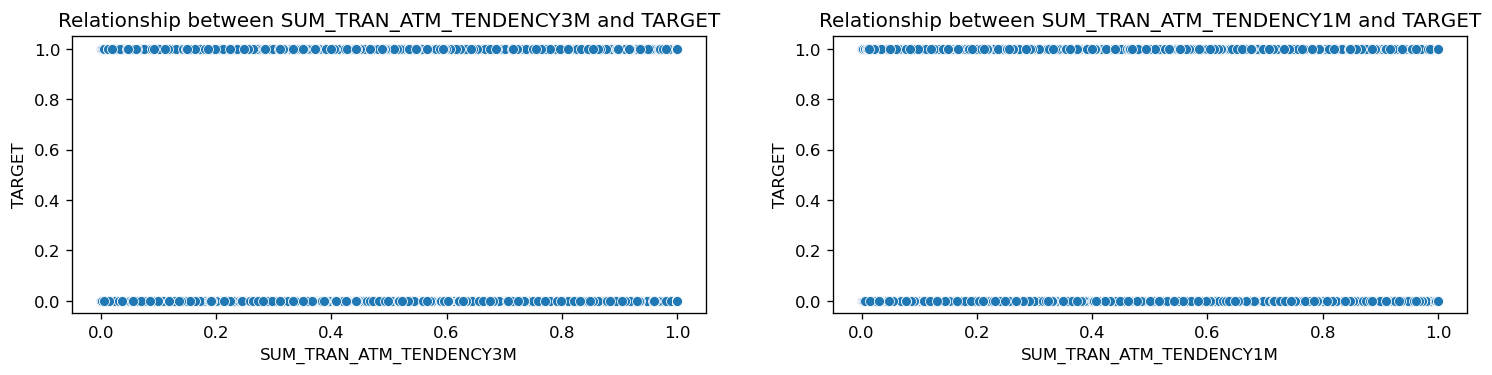

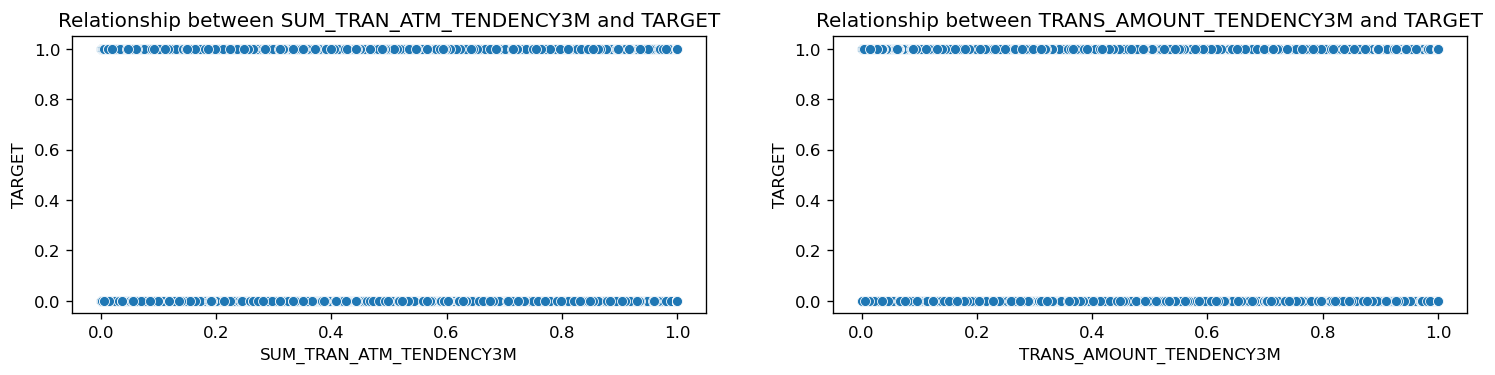

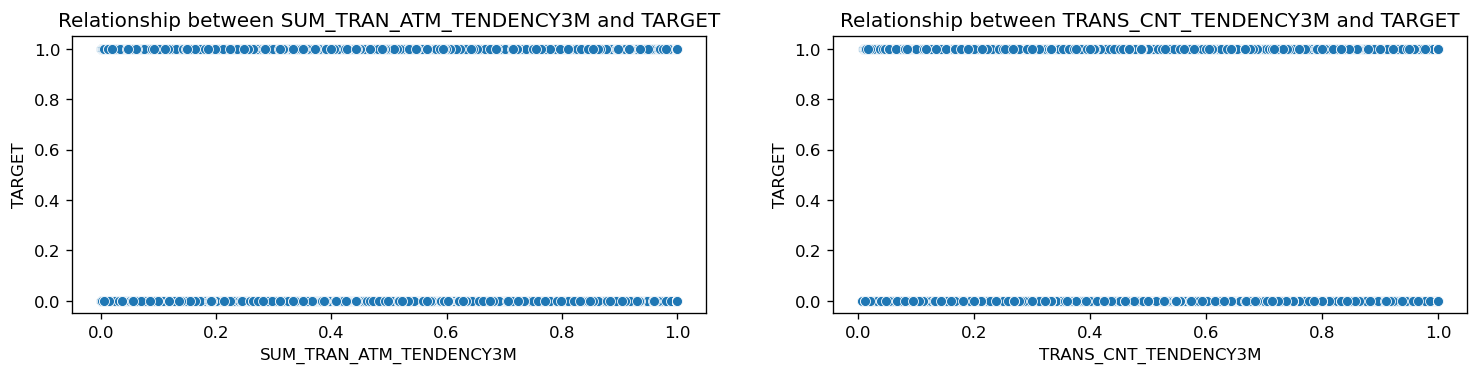

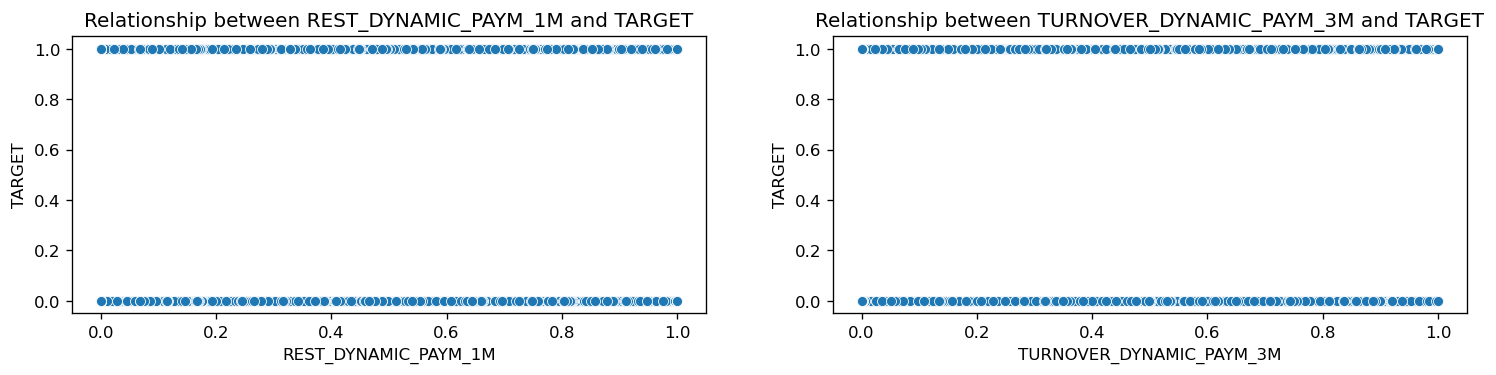

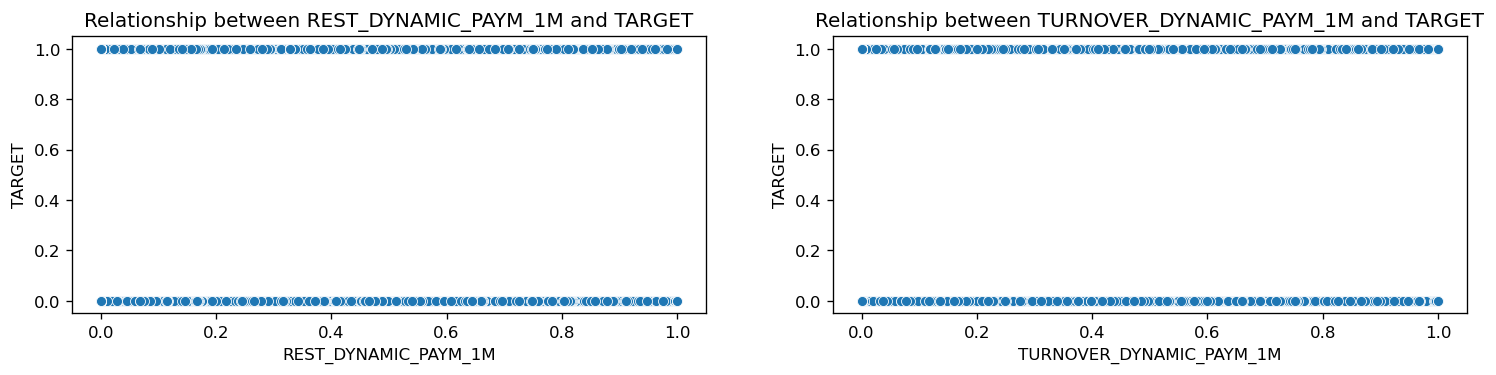

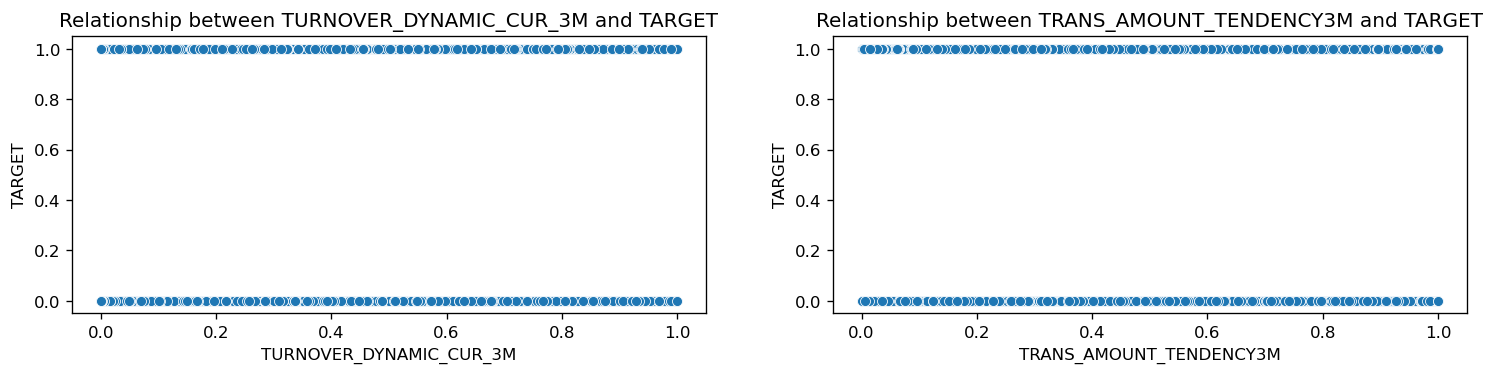

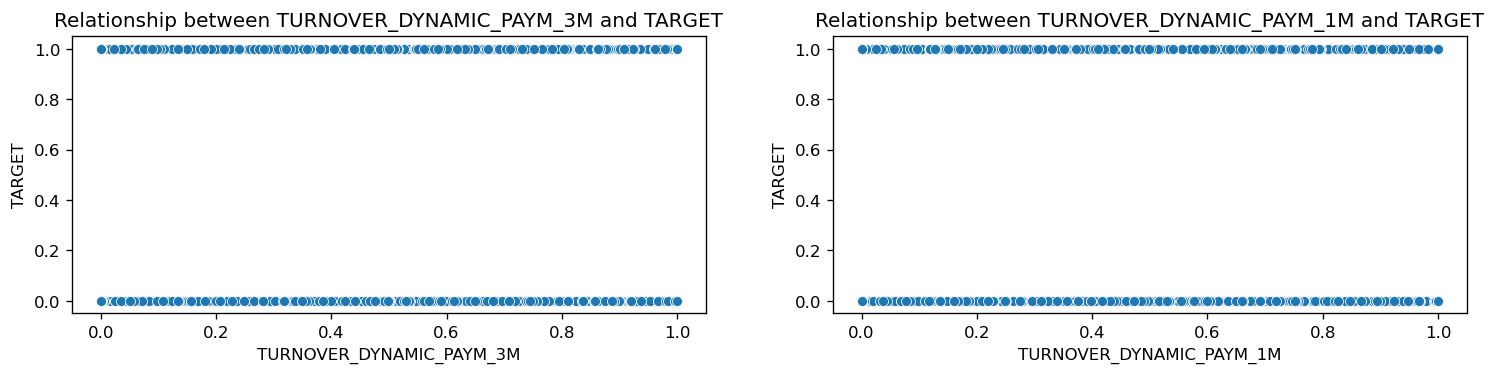

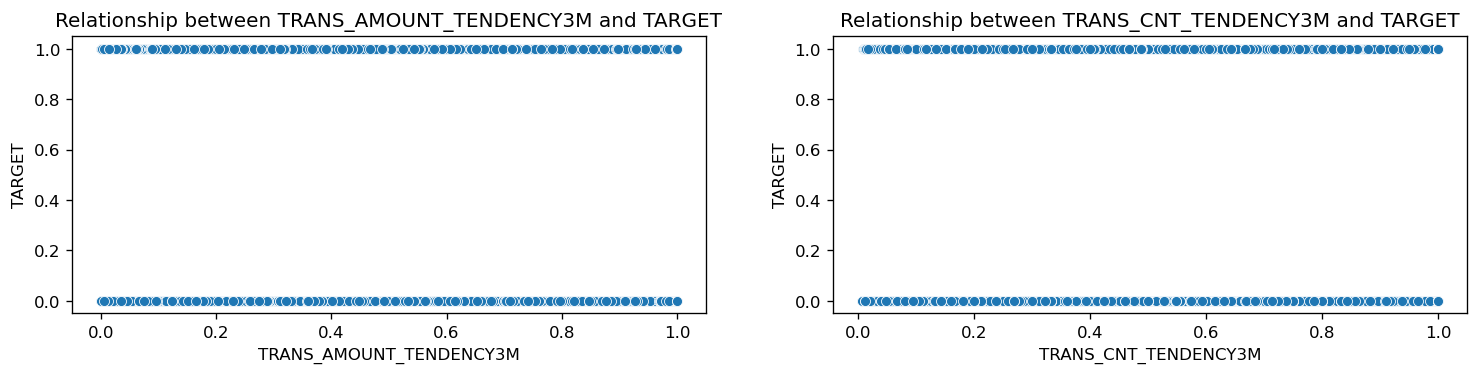

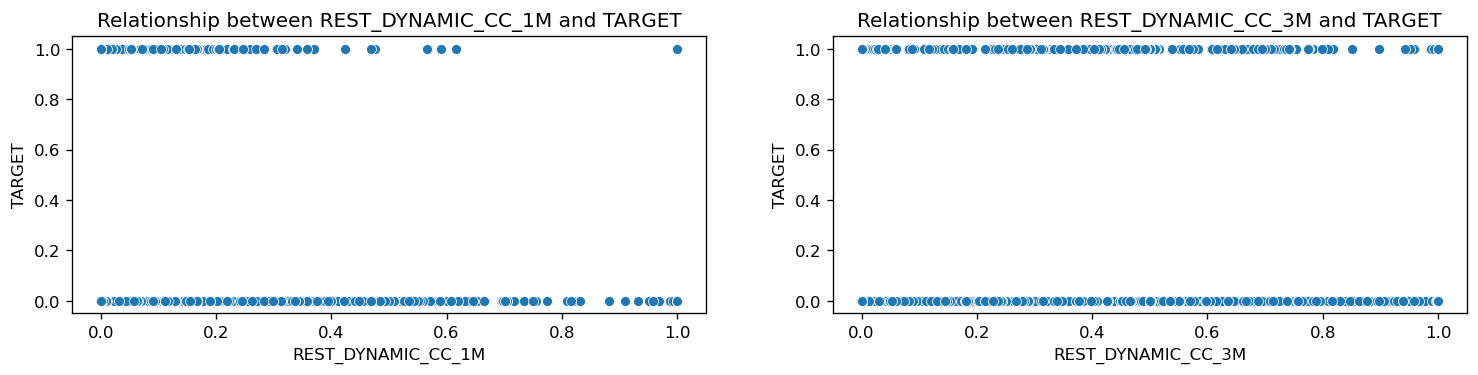

In [34]:
for i in range(high_corr_df.shape[0]):
    plt.figure(figsize=[15,3],dpi=120)
    col1 = high_corr_df['col1'].iloc[i]
    col2 = high_corr_df['col2'].iloc[i]
    plt.subplot(1,2,1)
    plt.title(f'Relationship between {col1} and TARGET')
    sns.scatterplot(data=df,x=col1,y='TARGET')
    plt.subplot(1,2,2)
    plt.title(f'Relationship between {col2} and TARGET')
    sns.scatterplot(data=df,x=col2,y='TARGET')
    plt.show()

Let's create two subsets

In [35]:
cols_keep_1 = high_corr_df['col1'].unique()
cols_keep_2 = high_corr_df['col2'].unique()

Now let's check for the distribution on the numerical null variables

In [36]:
null_counts = df.isnull().sum()

In [37]:
null_cols = list(null_counts[null_counts > 0].index)

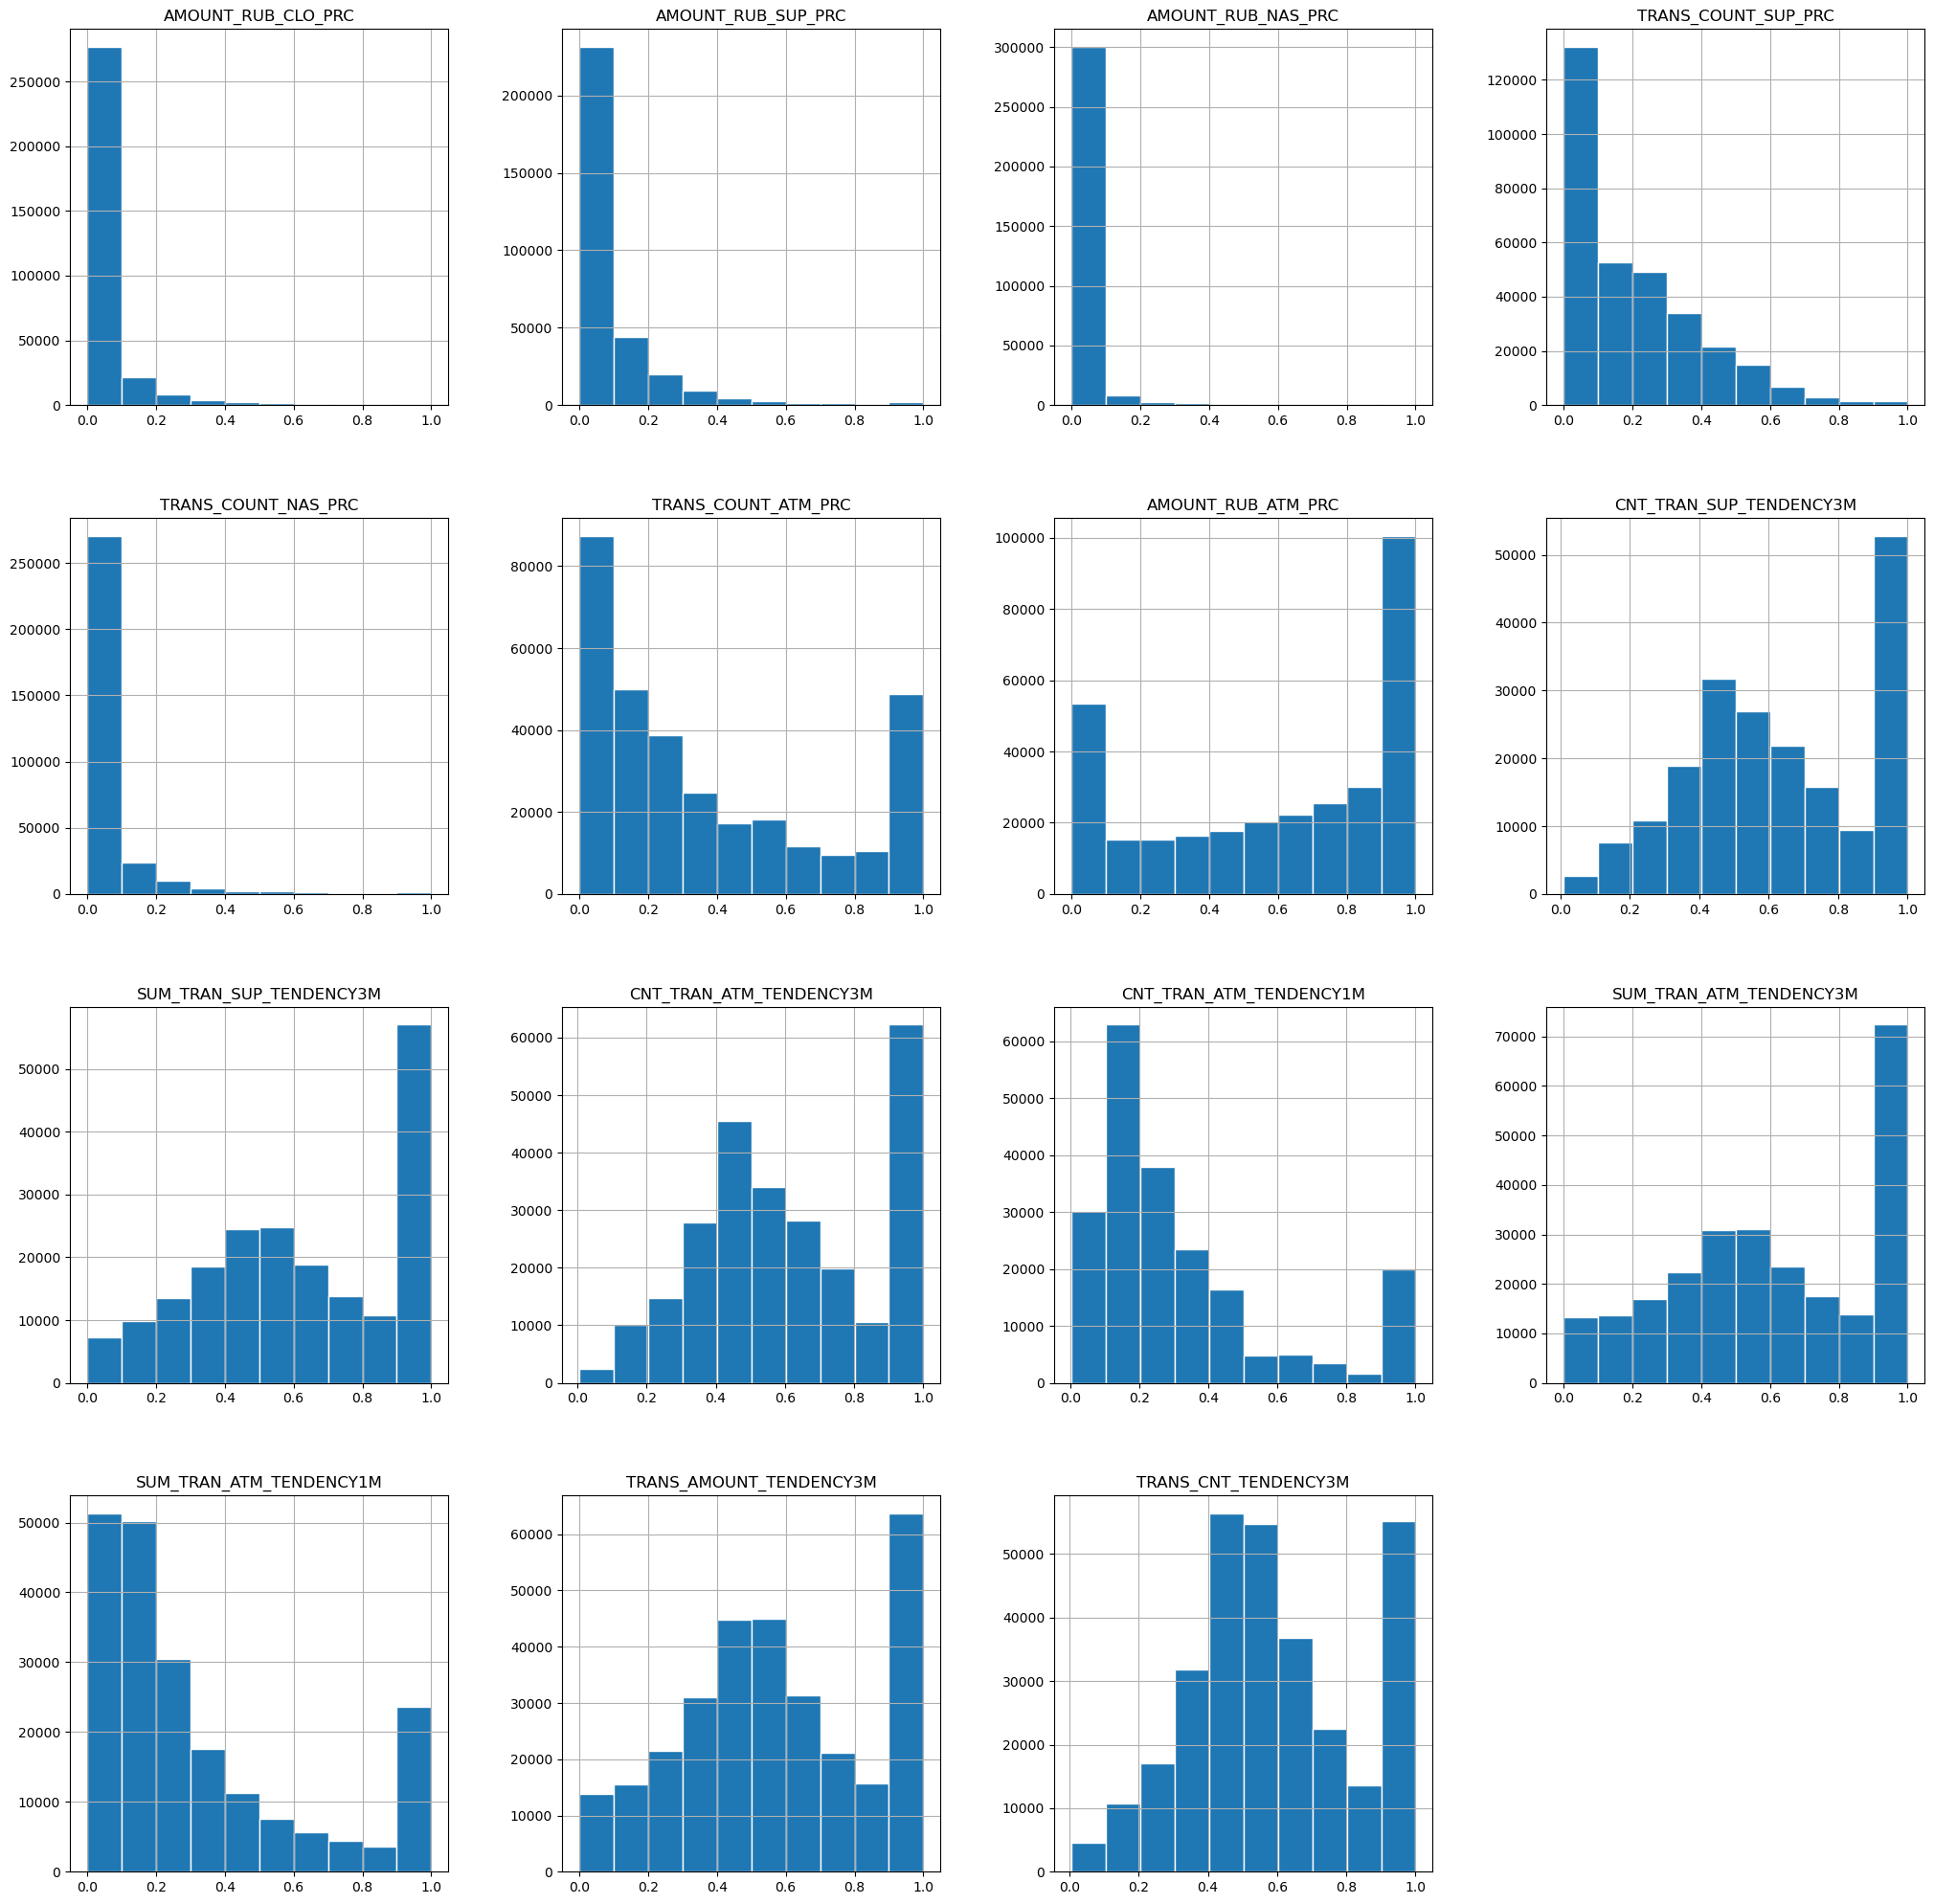

In [38]:
df[null_cols].hist(figsize=(25,25),ec='w')
plt.show()

Let's check one of the values that are very focused on the left side for example

In [39]:
df['REST_DYNAMIC_CC_1M'].describe(include='all')

count    355190.000000
mean          0.002191
std           0.026360
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: REST_DYNAMIC_CC_1M, dtype: float64


<b> We are going to use the grouped filling for the ones with a pattern on the distribution</b>
- We have a few columns that are highly concentrated in just one bin, for that we are going to use mode
- For the normally distributed we are going to use the mean.
- For the skewed we are going to use the median.

### Now let's check for Extreme Values/Outliers

In [40]:
cols = list(df.columns)
cols.remove('PACK')

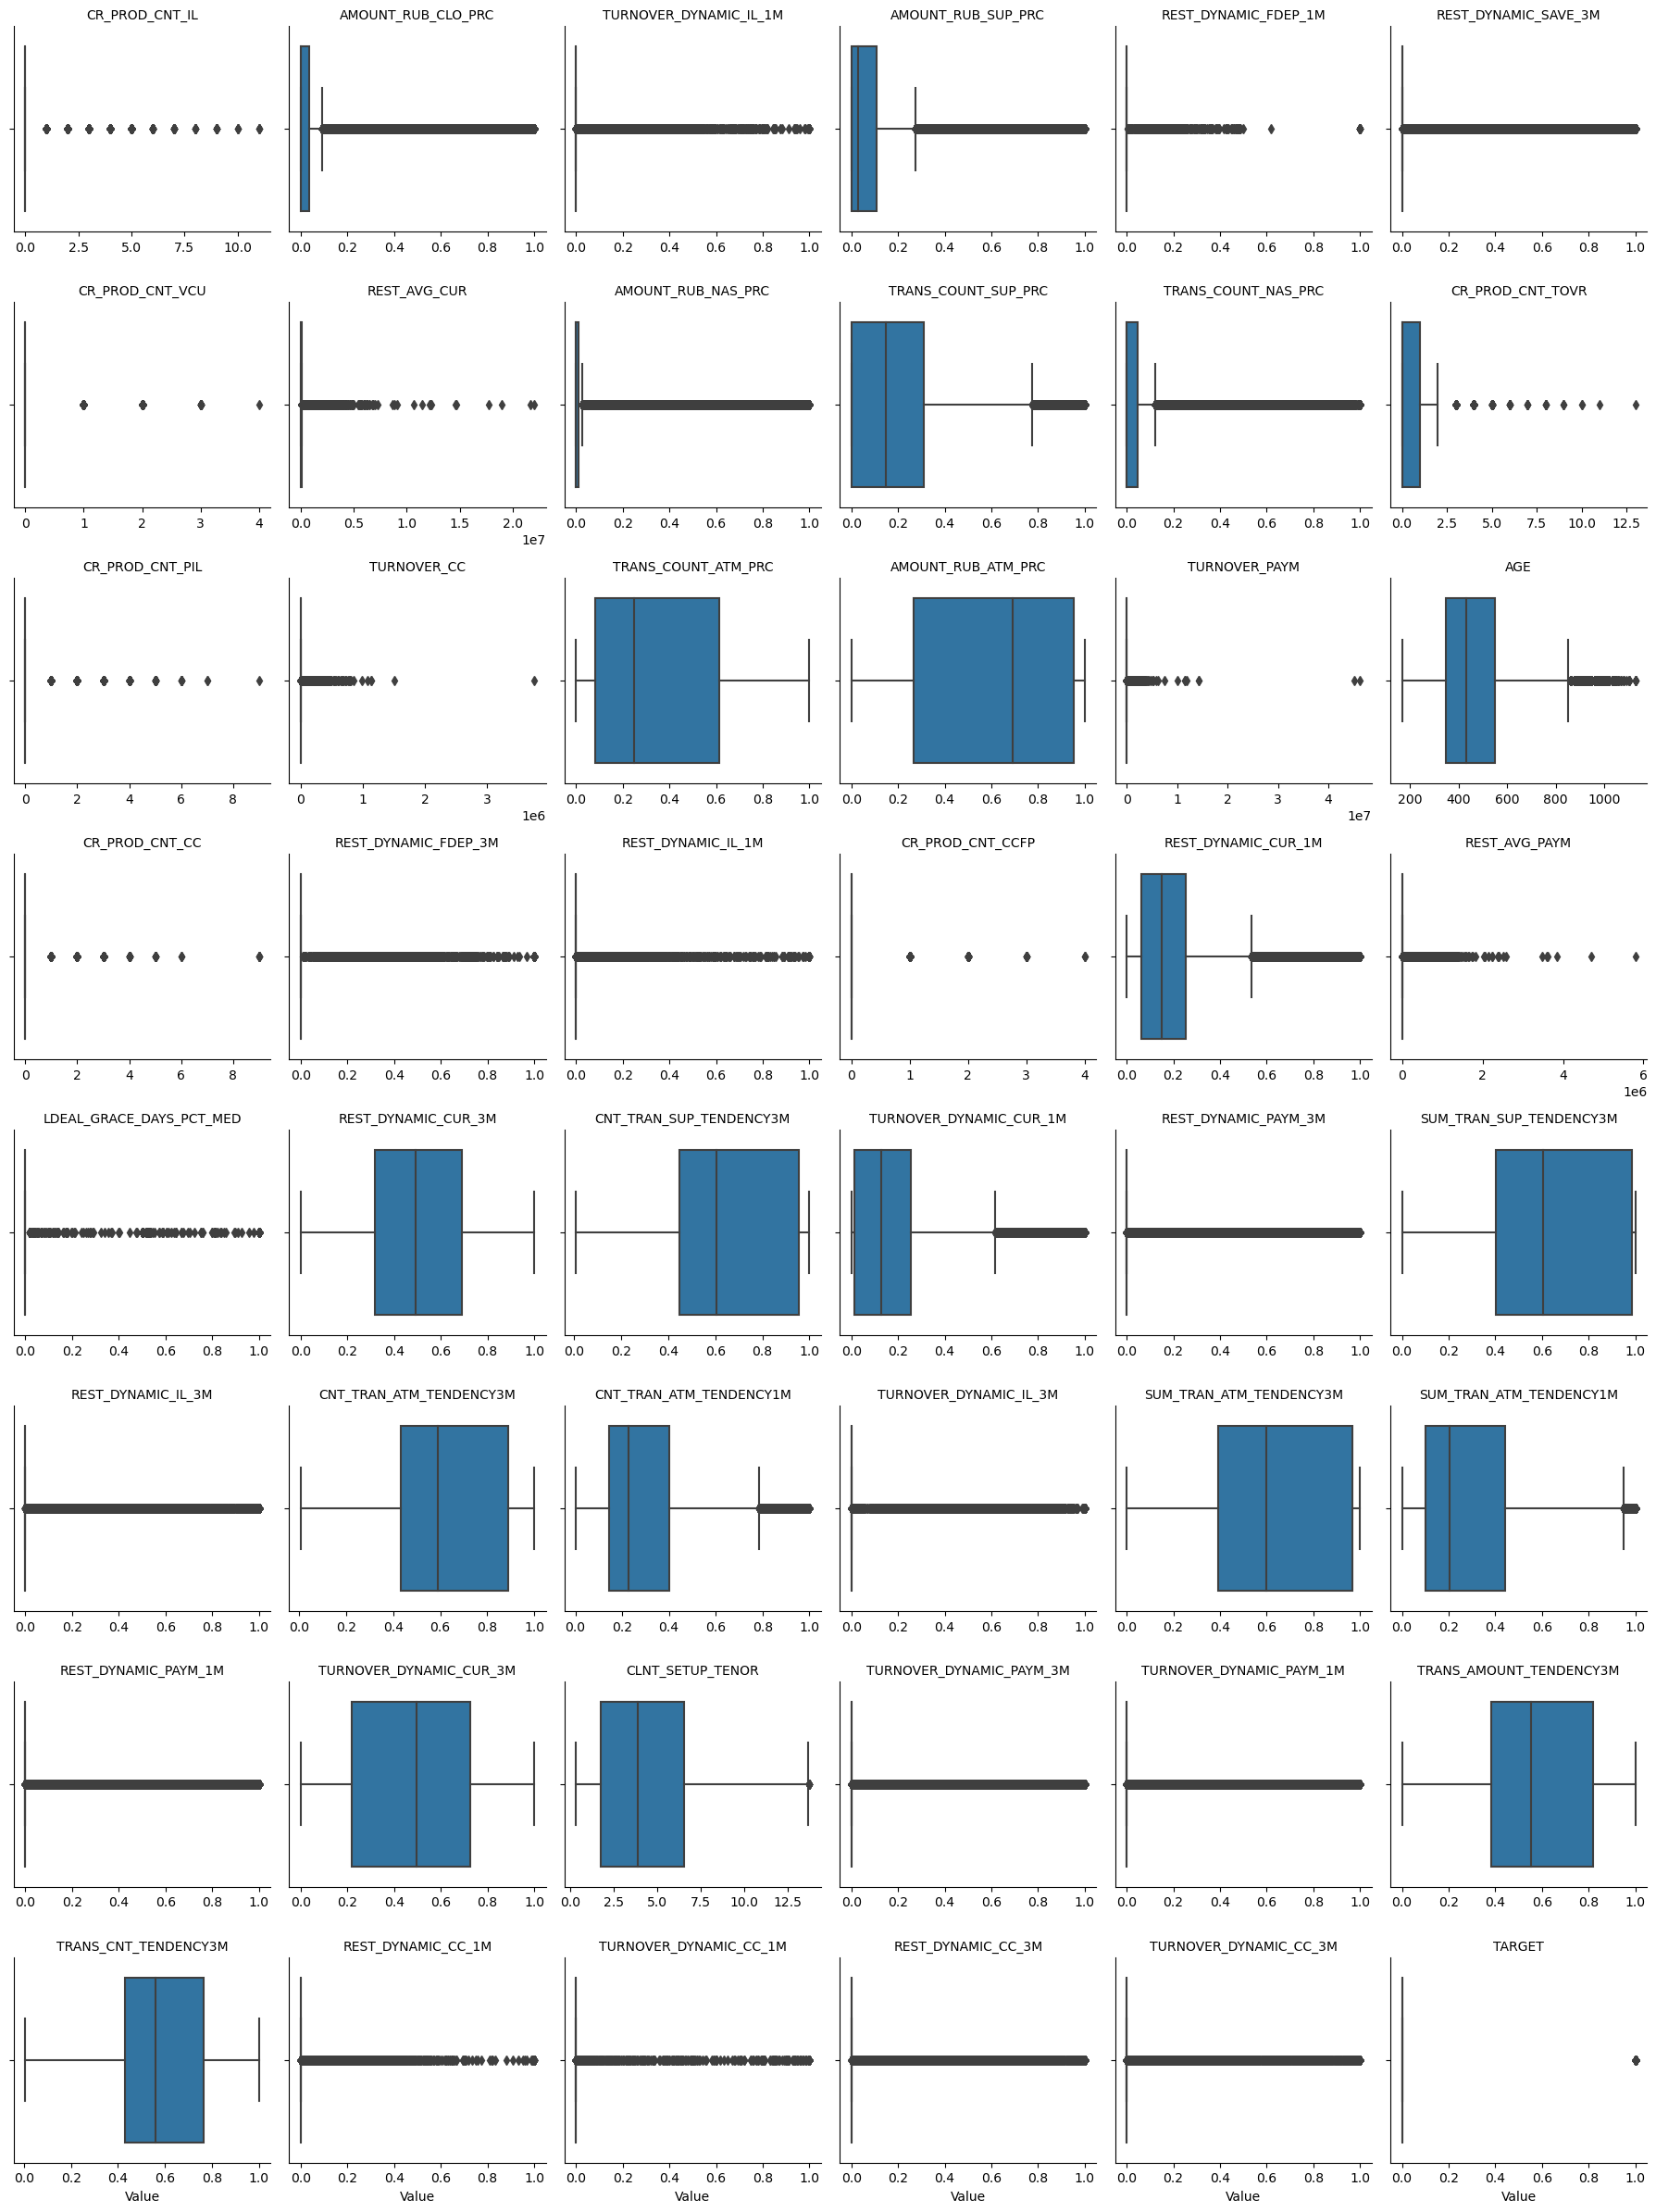

In [41]:
melted_df = pd.melt(df[cols], var_name='Variable', value_name='Value')

# Create a FacetGrid of boxplots
g = sns.FacetGrid(melted_df, col='Variable', col_wrap=6, sharex=False, sharey=False)
g.map(sns.boxplot, 'Value', orient='h')

# Optionally, adjust the axis labels and plot titles
g.set_titles("{col_name}")
g.set_axis_labels("Value", "")
plt.tight_layout()

# Show the plot
plt.show()

Right now we see a lot of outliers, but the thing is that we are dealing with Bank Data and every information is very sensitive specially for Churn or other models like Fraud. In this case we will keep outliers instead of treating them. But we may have to review it if we get bad results with our models

To wrap up EDA we have to check for imbalance

In [42]:
round((df.groupby(['TARGET']).size() / df.shape[0]) * 100,1)

TARGET
0    91.9
1     8.1
dtype: float64

Our dataset is imbalanced, so we may have to apply Over-Sampling or Under-Sampling or something in between using both techniques

In [92]:
df[['REST_AVG_CUR','REST_AVG_PAYM']].isnull().sum()

REST_AVG_CUR     0
REST_AVG_PAYM    0
dtype: int64

### Feature Engineering

To start feature engineering we will be doing the following:
- Splitting into train and test
- Filling nulls based on train
- Scaling our variables with the Standard Scaler
- One Hot encoding

In [43]:
X_col = list(df.columns)
X_col.remove('TARGET')
y_col = 'TARGET'

In [44]:
X_train,X_test,y_train,y_test = train_test_split(df[X_col],df[y_col],test_size= 0.25, random_state = 42)

Let's start with the ones that are concentrated

In [45]:
def get_mode(series):
    if not series.mode().empty:
        s = series.mode().iloc[0]  
        return s
    else:
        return None

In [46]:
imputation_dict = {
 'AMOUNT_RUB_CLO_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_CLO_PRC'].apply(get_mode).to_dict(),
 'AMOUNT_RUB_NAS_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_NAS_PRC'].apply(get_mode).to_dict(),
 'TRANS_COUNT_NAS_PRC' : X_train.groupby('PACK')['TRANS_COUNT_NAS_PRC'].apply(get_mode).to_dict()
}

In [47]:
pack_list = list(df['PACK'].unique())
pack_list.remove('108')
pack_list.remove('M01')
for item in df['PACK'].unique():
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_CLO_PRC'] = imputation_dict['AMOUNT_RUB_CLO_PRC'][item]
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_NAS_PRC'] = imputation_dict['AMOUNT_RUB_NAS_PRC'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_COUNT_NAS_PRC'] = imputation_dict['TRANS_COUNT_NAS_PRC'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_CLO_PRC'] = imputation_dict['AMOUNT_RUB_CLO_PRC'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_NAS_PRC'] = imputation_dict['AMOUNT_RUB_NAS_PRC'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_COUNT_NAS_PRC'] = imputation_dict['TRANS_COUNT_NAS_PRC'][item]

amount_clo = X_train['AMOUNT_RUB_CLO_PRC'].mode()[0]
amount_nas = X_train['AMOUNT_RUB_NAS_PRC'].mode()[0]
trans_nas = X_train['TRANS_COUNT_NAS_PRC'].mode()[0]
    
X_train['AMOUNT_RUB_CLO_PRC'].fillna(amount_clo,inplace = True)
X_train['AMOUNT_RUB_NAS_PRC'].fillna(amount_nas,inplace = True)
X_train['TRANS_COUNT_NAS_PRC'].fillna(trans_nas,inplace = True)
X_test['AMOUNT_RUB_CLO_PRC'].fillna(amount_clo,inplace = True)
X_test['AMOUNT_RUB_NAS_PRC'].fillna(amount_nas,inplace = True)
X_test['TRANS_COUNT_NAS_PRC'].fillna(trans_nas,inplace = True)

In [48]:
check = ['AMOUNT_RUB_CLO_PRC','AMOUNT_RUB_NAS_PRC','TRANS_COUNT_NAS_PRC']

In [49]:
X_train[check].isnull().sum()

AMOUNT_RUB_CLO_PRC     0
AMOUNT_RUB_NAS_PRC     0
TRANS_COUNT_NAS_PRC    0
dtype: int64

Let's go to the Skewed ones now

In [50]:
imputation_dict = {
 'AMOUNT_RUB_SUP_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_SUP_PRC'].median().to_dict(),
 'TRANS_COUNT_SUP_PRC' :  X_train.groupby('PACK')['TRANS_COUNT_SUP_PRC'].median().to_dict(),
 'TRANS_COUNT_ATM_PRC' : X_train.groupby('PACK')['TRANS_COUNT_ATM_PRC'].median().to_dict(),
 'AMOUNT_RUB_ATM_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_ATM_PRC'].median().to_dict(),
 'CNT_TRAN_ATM_TENDENCY1M' :  X_train.groupby('PACK')['CNT_TRAN_ATM_TENDENCY1M'].median().to_dict(),
 'SUM_TRAN_ATM_TENDENCY1M' :  X_train.groupby('PACK')['SUM_TRAN_ATM_TENDENCY1M'].median().to_dict()
}

In [51]:
pack_list = list(df['PACK'].unique())
pack_list.remove('108')
pack_list.remove('M01')
for item in df['PACK'].unique():
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_SUP_PRC'] = imputation_dict['AMOUNT_RUB_SUP_PRC'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_COUNT_SUP_PRC'] = imputation_dict['TRANS_COUNT_SUP_PRC'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_COUNT_ATM_PRC'] = imputation_dict['TRANS_COUNT_ATM_PRC'][item]
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
    X_train.loc[X_train['PACK']== item,'CNT_TRAN_ATM_TENDENCY1M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY1M'][item]
    X_train.loc[X_train['PACK']== item,'SUM_TRAN_ATM_TENDENCY1M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY1M'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_SUP_PRC'] = imputation_dict['AMOUNT_RUB_SUP_PRC'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_COUNT_SUP_PRC'] = imputation_dict['TRANS_COUNT_SUP_PRC'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_COUNT_ATM_PRC'] = imputation_dict['TRANS_COUNT_ATM_PRC'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
    X_test.loc[X_test['PACK']== item,'CNT_TRAN_ATM_TENDENCY1M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY1M'][item]
    X_test.loc[X_test['PACK']== item,'SUM_TRAN_ATM_TENDENCY1M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY1M'][item]

median_1 = X_train['AMOUNT_RUB_SUP_PRC'].median()
median_2 = X_train['TRANS_COUNT_SUP_PRC'].median()
median_3 = X_train['TRANS_COUNT_ATM_PRC'].median()
median_4 = X_train['AMOUNT_RUB_ATM_PRC'].median()
median_5 = X_train['CNT_TRAN_ATM_TENDENCY1M'].median()
median_6 = X_train['SUM_TRAN_ATM_TENDENCY1M'].median()
    
X_train['AMOUNT_RUB_SUP_PRC'].fillna(median_1,inplace = True)
X_train['TRANS_COUNT_SUP_PRC'].fillna(median_2,inplace = True)
X_train['TRANS_COUNT_ATM_PRC'].fillna(median_3,inplace = True)
X_train['AMOUNT_RUB_ATM_PRC'].fillna(median_4,inplace = True)
X_train['CNT_TRAN_ATM_TENDENCY1M'].fillna(median_5,inplace = True)
X_train['SUM_TRAN_ATM_TENDENCY1M'].fillna(median_6,inplace = True)
X_test['AMOUNT_RUB_SUP_PRC'].fillna(median_1,inplace = True)
X_test['TRANS_COUNT_SUP_PRC'].fillna(median_2,inplace = True)
X_test['TRANS_COUNT_ATM_PRC'].fillna(median_3,inplace = True)
X_test['AMOUNT_RUB_ATM_PRC'].fillna(median_4,inplace = True)
X_test['CNT_TRAN_ATM_TENDENCY1M'].fillna(median_5,inplace = True)
X_test['SUM_TRAN_ATM_TENDENCY1M'].fillna(median_6,inplace = True)

In [52]:
check = ['AMOUNT_RUB_SUP_PRC'
,'TRANS_COUNT_SUP_PRC'
,'TRANS_COUNT_ATM_PRC'
,'AMOUNT_RUB_ATM_PRC'
,'CNT_TRAN_ATM_TENDENCY1M'
,'SUM_TRAN_ATM_TENDENCY1M']

In [53]:
X_train[check].isnull().sum()

AMOUNT_RUB_SUP_PRC         0
TRANS_COUNT_SUP_PRC        0
TRANS_COUNT_ATM_PRC        0
AMOUNT_RUB_ATM_PRC         0
CNT_TRAN_ATM_TENDENCY1M    0
SUM_TRAN_ATM_TENDENCY1M    0
dtype: int64

Let's go to the Normal ones ones now

In [54]:
null_cols

['AMOUNT_RUB_CLO_PRC',
 'AMOUNT_RUB_SUP_PRC',
 'AMOUNT_RUB_NAS_PRC',
 'TRANS_COUNT_SUP_PRC',
 'TRANS_COUNT_NAS_PRC',
 'TRANS_COUNT_ATM_PRC',
 'AMOUNT_RUB_ATM_PRC',
 'CNT_TRAN_SUP_TENDENCY3M',
 'SUM_TRAN_SUP_TENDENCY3M',
 'CNT_TRAN_ATM_TENDENCY3M',
 'CNT_TRAN_ATM_TENDENCY1M',
 'SUM_TRAN_ATM_TENDENCY3M',
 'SUM_TRAN_ATM_TENDENCY1M',
 'TRANS_AMOUNT_TENDENCY3M',
 'TRANS_CNT_TENDENCY3M']

In [55]:
imputation_dict = {
 'CNT_TRAN_SUP_TENDENCY3M' :  X_train.groupby('PACK')['CNT_TRAN_SUP_TENDENCY3M'].mean().to_dict(),
 'SUM_TRAN_SUP_TENDENCY3M' :  X_train.groupby('PACK')['SUM_TRAN_SUP_TENDENCY3M'].mean().to_dict(),
 'CNT_TRAN_ATM_TENDENCY3M' : X_train.groupby('PACK') ['CNT_TRAN_ATM_TENDENCY3M'].mean().to_dict(),
 'AMOUNT_RUB_ATM_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_ATM_PRC'].mean().to_dict(),
 'SUM_TRAN_ATM_TENDENCY3M' :  X_train.groupby('PACK')['SUM_TRAN_ATM_TENDENCY3M'].mean().to_dict(),
 'TRANS_AMOUNT_TENDENCY3M' :  X_train.groupby('PACK')['TRANS_AMOUNT_TENDENCY3M'].mean().to_dict(),
 'TRANS_CNT_TENDENCY3M' :  X_train.groupby('PACK')['TRANS_CNT_TENDENCY3M'].mean().to_dict()
}

In [56]:
pack_list = list(df['PACK'].unique())
pack_list.remove('108')
pack_list.remove('M01')
for item in df['PACK'].unique():
    X_train.loc[X_train['PACK']== item,'CNT_TRAN_SUP_TENDENCY3M'] = imputation_dict['CNT_TRAN_SUP_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'SUM_TRAN_SUP_TENDENCY3M'] = imputation_dict['SUM_TRAN_SUP_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'CNT_TRAN_ATM_TENDENCY3M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
    X_train.loc[X_train['PACK']== item,'SUM_TRAN_ATM_TENDENCY3M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_AMOUNT_TENDENCY3M'] = imputation_dict['TRANS_AMOUNT_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_CNT_TENDENCY3M'] = imputation_dict['TRANS_CNT_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'CNT_TRAN_SUP_TENDENCY3M'] = imputation_dict['CNT_TRAN_SUP_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'SUM_TRAN_SUP_TENDENCY3M'] = imputation_dict['SUM_TRAN_SUP_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'CNT_TRAN_ATM_TENDENCY3M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
    X_test.loc[X_test['PACK']== item,'SUM_TRAN_ATM_TENDENCY3M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_AMOUNT_TENDENCY3M'] = imputation_dict['TRANS_AMOUNT_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_CNT_TENDENCY3M'] = imputation_dict['TRANS_CNT_TENDENCY3M'][item]

mean_1 = X_train['CNT_TRAN_SUP_TENDENCY3M'].mean()
mean_2 = X_train['SUM_TRAN_SUP_TENDENCY3M'].mean()
mean_3 = X_train['CNT_TRAN_ATM_TENDENCY3M'].mean()
mean_4 = X_train['AMOUNT_RUB_ATM_PRC'].mean()
mean_5 = X_train['SUM_TRAN_ATM_TENDENCY3M'].mean()
mean_6 = X_train['TRANS_AMOUNT_TENDENCY3M'].mean()
mean_7 = X_train['TRANS_CNT_TENDENCY3M'].mean()
    
X_train['CNT_TRAN_SUP_TENDENCY3M'].fillna(mean_1,inplace = True)
X_train['SUM_TRAN_SUP_TENDENCY3M'].fillna(mean_2,inplace = True)
X_train['CNT_TRAN_ATM_TENDENCY3M'].fillna(mean_3,inplace = True)
X_train['AMOUNT_RUB_ATM_PRC'].fillna(mean_4,inplace = True)
X_train['SUM_TRAN_ATM_TENDENCY3M'].fillna(mean_5,inplace = True)
X_train['TRANS_AMOUNT_TENDENCY3M'].fillna(mean_6,inplace = True)
X_train['TRANS_CNT_TENDENCY3M'].fillna(mean_7,inplace = True)
X_test['CNT_TRAN_SUP_TENDENCY3M'].fillna(mean_1,inplace = True)
X_test['SUM_TRAN_SUP_TENDENCY3M'].fillna(mean_2,inplace = True)
X_test['CNT_TRAN_ATM_TENDENCY3M'].fillna(mean_3,inplace = True)
X_test['AMOUNT_RUB_ATM_PRC'].fillna(mean_4,inplace = True)
X_test['SUM_TRAN_ATM_TENDENCY3M'].fillna(mean_5,inplace = True)
X_test['TRANS_AMOUNT_TENDENCY3M'].fillna(mean_6,inplace = True)
X_test['TRANS_CNT_TENDENCY3M'].fillna(mean_7,inplace = True)

In [57]:
check = ['CNT_TRAN_SUP_TENDENCY3M'
,'SUM_TRAN_SUP_TENDENCY3M'
,'CNT_TRAN_ATM_TENDENCY3M'
,'AMOUNT_RUB_ATM_PRC'
,'SUM_TRAN_ATM_TENDENCY3M'
,'TRANS_AMOUNT_TENDENCY3M'
,'TRANS_CNT_TENDENCY3M']

In [58]:
X_train[check].isnull().sum()

CNT_TRAN_SUP_TENDENCY3M    0
SUM_TRAN_SUP_TENDENCY3M    0
CNT_TRAN_ATM_TENDENCY3M    0
AMOUNT_RUB_ATM_PRC         0
SUM_TRAN_ATM_TENDENCY3M    0
TRANS_AMOUNT_TENDENCY3M    0
TRANS_CNT_TENDENCY3M       0
dtype: int64

We have to apply Onehot to the categorical, otherwise Standard Scaler won't work

In [59]:
oneh = OneHotEncoder(sparse_output=False)
oneh.fit(X_train[['PACK']])

OneHotEncoder(sparse_output=False)

In [60]:
col_names = oneh.get_feature_names_out()

In [61]:
X_train_dummies = pd.DataFrame(oneh.transform(X_train[['PACK']]),columns = col_names)
X_train_dummies.index = X_train.index
X_train = pd.merge(X_train,X_train_dummies,left_index=True,right_index=True)

X_test_dummies = pd.DataFrame(oneh.transform(X_test[['PACK']]),columns = col_names)
X_test_dummies.index = X_test.index
X_test = pd.merge(X_test,X_test_dummies,left_index=True,right_index=True)

In [62]:
X_train.drop(columns = 'PACK',inplace = True)
X_test.drop(columns = 'PACK',inplace = True)

Now to scale we are using the Standard Scaler

In [63]:
scaler = StandardScaler()

In [64]:
scaler.fit(X_train)

StandardScaler()

In [65]:
X_train_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [66]:
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

Below we will create a list of columns that we will be using

In [67]:
cols_to_use1 = list(X_train.columns)
cols_to_use2 = list(X_train.columns)

In [68]:
for col in cols_keep_2:
    cols_to_use1.remove(col)
    
for col in cols_keep_1:
    cols_to_use2.remove(col)

In [80]:
cols_to_use1

['CR_PROD_CNT_IL',
 'AMOUNT_RUB_CLO_PRC',
 'TURNOVER_DYNAMIC_IL_1M',
 'AMOUNT_RUB_SUP_PRC',
 'REST_DYNAMIC_FDEP_1M',
 'REST_DYNAMIC_SAVE_3M',
 'CR_PROD_CNT_VCU',
 'REST_AVG_CUR',
 'AMOUNT_RUB_NAS_PRC',
 'CR_PROD_CNT_TOVR',
 'CR_PROD_CNT_PIL',
 'TURNOVER_CC',
 'TRANS_COUNT_ATM_PRC',
 'TURNOVER_PAYM',
 'AGE',
 'CR_PROD_CNT_CC',
 'REST_DYNAMIC_IL_1M',
 'CR_PROD_CNT_CCFP',
 'REST_DYNAMIC_CUR_1M',
 'REST_AVG_PAYM',
 'LDEAL_GRACE_DAYS_PCT_MED',
 'CNT_TRAN_SUP_TENDENCY3M',
 'REST_DYNAMIC_PAYM_3M',
 'CNT_TRAN_ATM_TENDENCY3M',
 'CLNT_SETUP_TENOR',
 'REST_DYNAMIC_CC_1M',
 'TURNOVER_DYNAMIC_CC_1M',
 'TURNOVER_DYNAMIC_CC_3M',
 'PACK_101',
 'PACK_102',
 'PACK_103',
 'PACK_104',
 'PACK_105',
 'PACK_107',
 'PACK_108',
 'PACK_109',
 'PACK_301',
 'PACK_K01',
 'PACK_M01',
 'PACK_O01']

In [81]:
for item in ['PACK_101', 'PACK_102', 'PACK_103',
       'PACK_104', 'PACK_105', 'PACK_107', 'PACK_108', 'PACK_109', 'PACK_301',
       'PACK_K01', 'PACK_M01', 'PACK_O01']:
    cols_to_use1.remove(item)

In [82]:
model = LogisticRegression(max_iter=400)
rfe = RFE(estimator=model, n_features_to_select=15, step=1)
rfe = rfe.fit(X_train[cols_to_use1], y_train)

In [83]:
rfe_columns = list(rfe.get_feature_names_out())

In [84]:
rfe_columns

['CR_PROD_CNT_IL',
 'TURNOVER_DYNAMIC_IL_1M',
 'REST_DYNAMIC_FDEP_1M',
 'REST_AVG_CUR',
 'CR_PROD_CNT_PIL',
 'TRANS_COUNT_ATM_PRC',
 'AGE',
 'REST_DYNAMIC_IL_1M',
 'REST_DYNAMIC_CUR_1M',
 'REST_AVG_PAYM',
 'CNT_TRAN_SUP_TENDENCY3M',
 'REST_DYNAMIC_PAYM_3M',
 'CNT_TRAN_ATM_TENDENCY3M',
 'CLNT_SETUP_TENOR',
 'REST_DYNAMIC_CC_1M']

In [85]:
for item in ['PACK_101', 'PACK_102', 'PACK_103',
       'PACK_104', 'PACK_105', 'PACK_107', 'PACK_108', 'PACK_109', 'PACK_301',
       'PACK_K01', 'PACK_M01', 'PACK_O01']:
    rfe_columns.append(item)

In [86]:
rfe_columns

['CR_PROD_CNT_IL',
 'TURNOVER_DYNAMIC_IL_1M',
 'REST_DYNAMIC_FDEP_1M',
 'REST_AVG_CUR',
 'CR_PROD_CNT_PIL',
 'TRANS_COUNT_ATM_PRC',
 'AGE',
 'REST_DYNAMIC_IL_1M',
 'REST_DYNAMIC_CUR_1M',
 'REST_AVG_PAYM',
 'CNT_TRAN_SUP_TENDENCY3M',
 'REST_DYNAMIC_PAYM_3M',
 'CNT_TRAN_ATM_TENDENCY3M',
 'CLNT_SETUP_TENOR',
 'REST_DYNAMIC_CC_1M',
 'PACK_101',
 'PACK_102',
 'PACK_103',
 'PACK_104',
 'PACK_105',
 'PACK_107',
 'PACK_108',
 'PACK_109',
 'PACK_301',
 'PACK_K01',
 'PACK_M01',
 'PACK_O01']

In [90]:
X_train[rfe_columns].to_parquet('X_train_data_filtered.parquet')
X_test[rfe_columns].to_parquet('X_test_data_filtered.parquet')
X_train.to_parquet('X_train_data.parquet')
X_test.to_parquet('X_test_data.parquet')
y_train.to_frame().to_parquet('y_train_data.parquet')
y_test.to_frame().to_parquet('y_test_data.parquet')

Now to start modelling!

Let's use an Undersample Technique to make it better for logistic regression and SVM's to run, and with first set of columns.

- The Technique is Called NearMiss.

In [69]:
def undersampling(X, y):
    
    # Identify majority and minority classes
    classes, counts = np.unique(y, return_counts=True)
    minority_class_count = min(counts)
    
    # This will balance the majority class with the minority class
    nm = NearMiss()
    
    # Perform the undersampling
    X_resampled, y_resampled = nm.fit_resample(X, y)
    
    
    return X_resampled, y_resampled

In [70]:
X_train,y_train = undersampling(X_train,y_train)

In [71]:
y_train = y_train.to_frame()

In [72]:
y_train.groupby(['TARGET']).size()

TARGET
0    21711
1    21711
dtype: int64

### Now to the models!!

Let's decide on the first set of columns based on the logistic regression

In [73]:
# Starting Linear Regression
logr = LogisticRegression()

#Fitting Linear Regression
logr.fit(X_train[cols_to_use1],y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train[cols_to_use1]))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test[cols_to_use1]))))

Accuracy of training is 0.7910045599005112
Precision of training is 0.8709923664122138
Recall of training is 0.6832020634701303
F1 of training is 0.7657520456364059
ROC AUC of training is 0.7910045599005113

Accuracy of test is 0.2785986170859704
Precision of test is 0.0728059759818436
Recall of test is 0.6714721375103965
F1 of test is 0.13136805564972134
ROC AUC of test is 0.4576656137640235


In [74]:
# Starting Linear Regression
logr = LogisticRegression()

#Fitting Linear Regression
logr.fit(X_train[cols_to_use2],y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train[cols_to_use2]))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train[cols_to_use2]))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train[cols_to_use2]))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train[cols_to_use2]))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train[cols_to_use2]))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test[cols_to_use2]))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test[cols_to_use2]))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test[cols_to_use2]))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test[cols_to_use2]))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test[cols_to_use2]))))

Accuracy of training is 0.7878725070240892
Precision of training is 0.8772332206663448
Recall of training is 0.6694302427340979
F1 of training is 0.7593719794143002
ROC AUC of training is 0.7878725070240892

Accuracy of test is 0.2838126984842001
Precision of test is 0.07170854729421774
Recall of test is 0.6542833379539784
F1 of test is 0.12925132811216386
ROC AUC of test is 0.4526687331072109


### Since there is not much of a difference between set 1 and 2, we will be tending to set 1

In [81]:
# Starting Linear Regression
svc = SVC()

#Fitting Linear Regression
svc.fit(X_train[cols_to_use1],y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,svc.predict(X_train[cols_to_use1]))))
print('Precision of training is '+ str(precision_score(y_train,svc.predict(X_train[cols_to_use1]))))
print('Recall of training is '+ str(recall_score(y_train,svc.predict(X_train[cols_to_use1]))))
print('F1 of training is '+ str(f1_score(y_train,svc.predict(X_train[cols_to_use1]))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,svc.predict(X_train[cols_to_use1]))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,svc.predict(X_test[cols_to_use1]))))
print('Precision of test is '+ str(precision_score(y_test,svc.predict(X_test[cols_to_use1]))))
print('Recall of test is '+ str(recall_score(y_test,svc.predict(X_test[cols_to_use1]))))
print('F1 of test is '+ str(f1_score(y_test,svc.predict(X_test[cols_to_use1]))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,svc.predict(X_test[cols_to_use1]))))

Accuracy of training is 0.8012988807516926
Precision of training is 0.8953284583308152
Recall of training is 0.682372990649901
F1 of training is 0.7744785404359873
ROC AUC of training is 0.8012988807516928

Accuracy of test is 0.2891393950314196
Precision of test is 0.07390979621077019
Recall of test is 0.6721652342667036
F1 of test is 0.1331758695980555
ROC AUC of test is 0.46371793778445985


In [84]:
# Starting XGBoost
logr = XGBClassifier(n_estimators = 1000, learning_rate=0.01)

#Fitting
logr.fit(X_train[cols_to_use1],y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train[cols_to_use1]))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test[cols_to_use1]))))

Accuracy of training is 0.8427064621620377
Precision of training is 0.9216775290450553
Recall of training is 0.749067293077242
F1 of training is 0.8264559406443744
ROC AUC of training is 0.8427064621620377

Accuracy of test is 0.2621230207887565
Precision of test is 0.07696325962040745
Recall of test is 0.7352370390906571
F1 of test is 0.139340601602522
ROC AUC of test is 0.4777626654562915


In [85]:
# Starting XGBoost
logr = LGBMClassifier(n_estimators = 1000, learning_rate=0.01)

#Fitting
logr.fit(X_train[cols_to_use1],y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train[cols_to_use1]))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test[cols_to_use1]))))

[LightGBM] [Info] Number of positive: 21711, number of negative: 21711
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2437
[LightGBM] [Info] Number of data points in the train set: 43422, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy of training is 0.8500069089401686
Precision of training is 0.9161099550980177
Recall of training is 0.7705771268020819
F1 of training is 0.8370650188877492
ROC AUC of training is 0.8500069089401686

Accuracy of test is 0.2475618820243699
Precision of test is 0.07700387503371138
Recall of test is 0.7520099805932908
F1 of test is 0.13970256872465076
ROC AUC of test is 0.47748322132233667


In [89]:
# Starting XGBoost
logr = RandomForestClassifier()

#Fitting
logr.fit(X_train[cols_to_use1],y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train[cols_to_use1]))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train[cols_to_use1]))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test[cols_to_use1]))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test[cols_to_use1]))))

Accuracy of training is 0.9999078807977523
Precision of training is 0.9999078807977523
Recall of training is 0.9999078807977523
F1 of training is 0.9999078807977523
ROC AUC of training is 0.9999078807977524

Accuracy of test is 0.23650307439356744
Precision of test is 0.07723548868822487
Recall of test is 0.7671194898807874
F1 of test is 0.14034108920306854
ROC AUC of test is 0.4783516158954829


### None of the models are good so far. So let's try regularization and Recursive Feature Extraction

In [118]:
# Starting XGBoost
logr = XGBClassifier(n_estimators = 1000, learning_rate=0.01)

#Fitting
logr.fit(X_train[rfe_columns],y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train[rfe_columns]))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train[rfe_columns]))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train[rfe_columns]))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train[rfe_columns]))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train[rfe_columns]))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test[rfe_columns]))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test[rfe_columns]))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test[rfe_columns]))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test[rfe_columns]))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test[rfe_columns]))))

Accuracy of training is 0.8106029201787113
Precision of training is 0.8766266406031835
Recall of training is 0.7229514992400166
F1 of training is 0.7924071082390953
ROC AUC of training is 0.8106029201787113

Accuracy of test is 0.2705353724182977
Precision of test is 0.07575288550833591
Recall of test is 0.71236484613252
F1 of test is 0.13694322678640428
ROC AUC of test is 0.4719159002186428


Let's try cross validation

In [136]:
# Initialize the XGBClassifier
xgb_clf = XGBClassifier(eval_metric='aucpr')

# Perform 10-fold cross-validation
scores = cross_val_score(xgb_clf, X_train[rfe_columns], y_train, cv=10)

In [138]:
print(f"Mean CV accuracy: {scores.mean()}")

Mean CV accuracy: 0.781795225680699


Let's try to remove the overfitting with a ParamGrid Cross Validation

In [78]:
param_grid = {
    'num_leaves': [31, 50], #Number of leaves parameter        
    'max_depth': [-1, 5],  # Max depth parameter
    'learning_rate': [0.001,0.01,0.05], #Learning Rate Parameter
    'n_estimators': [500,1000], #Number of fitted trees       
    'subsample': [0.8, 0.9], #Subsample number           
    'colsample_bytree': [0.8, 0.9] #number of colsample bytree
}

We are using the above param grid with some parameters within the range of the default parameters.
- For the Cross Validation we specify inside the cv parameter of the GridSearchCV with 10 folds and after that it will do the magic for us.

In [79]:
xgb_grid = XGBClassifier(random_state = 42)
# Setup RandomizedSearchCV
grid_search = GridSearchCV(
    estimator=xgb_grid, 
    scoring= 'f1',
    param_grid=param_grid, 
    cv=10, 
    verbose=1, 
    n_jobs=-1  # Use all available cores
)

# Perform the random search
grid_search.fit(X_train[rfe_columns], y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 31, 'subsample': 0.9}
Best score found:  0.7748701437901795


In [80]:
#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,grid_search.predict(X_train[rfe_columns]))))
print('Precision of training is '+ str(precision_score(y_train,grid_search.predict(X_train[rfe_columns]))))
print('Recall of training is '+ str(recall_score(y_train,grid_search.predict(X_train[rfe_columns]))))
print('F1 of training is '+ str(f1_score(y_train,grid_search.predict(X_train[rfe_columns]))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,grid_search.predict(X_train[rfe_columns]))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,grid_search.predict(X_test[rfe_columns]))))
print('Precision of test is '+ str(precision_score(y_test,grid_search.predict(X_test[rfe_columns]))))
print('Recall of test is '+ str(recall_score(y_test,grid_search.predict(X_test[rfe_columns]))))
print('F1 of test is '+ str(f1_score(y_test,grid_search.predict(X_test[rfe_columns]))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,grid_search.predict(X_test[rfe_columns]))))

Accuracy of training is 0.8173045921422321
Precision of training is 0.8803555653710248
Recall of training is 0.7344203399198563
F1 of training is 0.8007935112874469
ROC AUC of training is 0.8173045921422321

Accuracy of test is 0.26978085092006576
Precision of test is 0.07660093455197343
Recall of test is 0.7226226781258663
F1 of test is 0.13851836105649146
ROC AUC of test is 0.47618067618785964


Checking the Confusion_matrix Matrix and ROC AUC

In [82]:
cm = confusion_matrix(y_test,grid_search.predict(X_test[rfe_columns]))

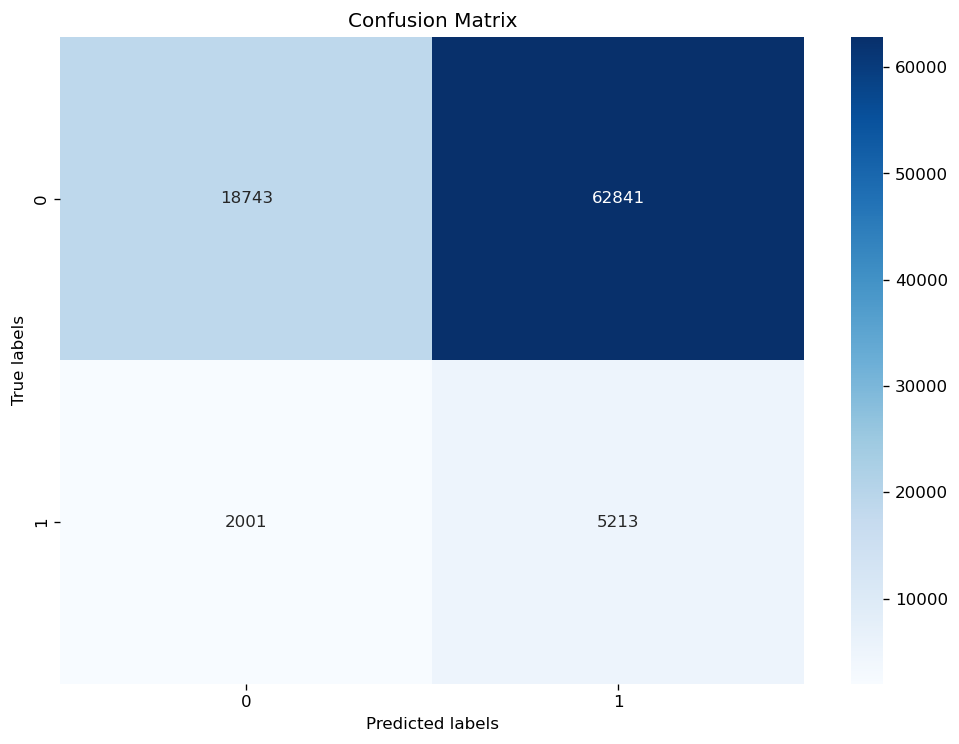

In [85]:
# Plotting the confusion matrix
plt.figure(figsize=(10,7),dpi=120)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [140]:
y_prob = grid_search.predict_proba(X_test[rfe_columns])[:, 1]

In [144]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

In [147]:
roc_auc = auc(fpr, tpr)

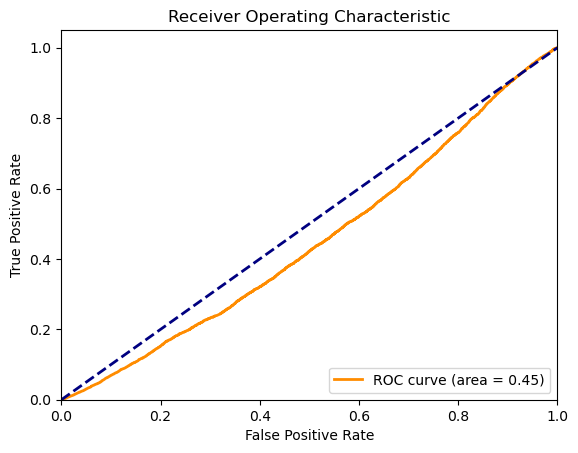

In [148]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

As we can see even after fixing the imbalance of the dataset and running multiple models we couldn't find a good model, maybe we are lacking a few variables yet!